# DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 

Dense and regression tasks

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys
sys.path.append('../..')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [14]:
from GHCN_preprocessing import get_data, get_stations, sphereGraph, clean_nodes

In [4]:
import numpy as np
from scipy import sparse

def regression_tikhonov(G, y, M, tau=0):
    r"""Solve a regression problem on graph via Tikhonov minimization.
    The function solves
    .. math:: \operatorname*{arg min}_x \| M x - y \|_2^2 + \tau \ x^T L x
    if :math:`\tau > 0`, and
    .. math:: \operatorname*{arg min}_x x^T L x \ \text{ s. t. } \ y = M x
    otherwise.
    Parameters
    ----------
    G : :class:`pygsp.graphs.Graph`
    y : array, length G.n_vertices
        Measurements.
    M : array of boolean, length G.n_vertices
        Masking vector.
    tau : float
        Regularization parameter.
    Returns
    -------
    x : array, length G.n_vertices
        Recovered values :math:`x`.
    Examples
    --------
    >>> from pygsp import graphs, filters, learning
    >>> import matplotlib.pyplot as plt
    >>>
    >>> G = graphs.Sensor(N=100, seed=42)
    >>> G.estimate_lmax()
    Create a smooth ground truth signal:
    >>> filt = lambda x: 1 / (1 + 10*x)
    >>> filt = filters.Filter(G, filt)
    >>> rs = np.random.RandomState(42)
    >>> signal = filt.analyze(rs.normal(size=G.n_vertices))
    Construct a measurement signal from a binary mask:
    >>> mask = rs.uniform(0, 1, G.n_vertices) > 0.5
    >>> measures = signal.copy()
    >>> measures[~mask] = np.nan
    Solve the regression problem by reconstructing the signal:
    >>> recovery = learning.regression_tikhonov(G, measures, mask, tau=0)
    Plot the results:
    >>> fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
    >>> limits = [signal.min(), signal.max()]
    >>> _ = G.plot_signal(signal, ax=ax1, limits=limits, title='Ground truth')
    >>> _ = G.plot_signal(measures, ax=ax2, limits=limits, title='Measures')
    >>> _ = G.plot_signal(recovery, ax=ax3, limits=limits, title='Recovery')
    >>> _ = fig.tight_layout()
    """

    if tau > 0:

        y[M == False] = 0

        if sparse.issparse(G.L):

            def Op(x):
                return (M * x.T).T + tau * (G.L.dot(x))

            LinearOp = sparse.linalg.LinearOperator([G.N, G.N], Op)

            if y.ndim > 1:
                sol = np.empty(shape=y.shape)
                res = np.empty(shape=y.shape[1])
                for i in range(y.shape[1]):
                    sol[:, i], res[i] = sparse.linalg.cg(
                        LinearOp, y[:, i])
            else:
                sol, res = sparse.linalg.cg(LinearOp, y)

            # TODO: do something with the residual...
            return sol

        else:

            # Creating this matrix may be problematic in term of memory.
            # Consider using an operator instead...
            if type(G.L).__module__ == np.__name__:
                LinearOp = np.diag(M*1) + tau * G.L
            return np.linalg.solve(LinearOp, M * y)

    else:

        if np.prod(M.shape) != G.n_vertices:
            raise ValueError("M should be of size [G.n_vertices,]")

        indl = M
        indu = (M == False)

        Luu = G.L[indu, :][:, indu]
        Wul = - G.L[indu, :][:, indl]

        if sparse.issparse(G.L):
            sol_part = sparse.linalg.spsolve(Luu, Wul.dot(y[indl]))
        else:
            sol_part = np.linalg.solve(Luu, np.matmul(Wul, y[indl]))

        sol = y.copy()
        sol[indu] = sol_part

        return sol

In [5]:
datapath = "/mnt/nas/LTS2/datasets/ghcn-daily/processed/"
rawpath = "/mnt/nas/LTS2/datasets/ghcn-daily/raw/"
newdatapath = "./data/ghcn-daily/processed/"

In [7]:
years = np.arange(2010,2015)
years2 = np.arange(2010,2018)

feature_names = ['PRCP', 'TMIN', 'TMAX', 'SNOW', 'SNWD', 'WT']
# max stations, 50'469
# in 2010, in nbr stations [36k, 16k, 16k, 6k, 22k, (20k, 0, 0, 28, 1k, 6), 5k]
# in 2011, in nbr stations [36k, 16k, 16k, 6k, 22k, (18k, 0, 0, 38, 1k, 22), 5k]
# in 2014, in nbr stations [39k, 15k, 15k, 6k, 24k, (19k, 0, 0, 40, 1k, 49), 4k]
n_features = len(feature_names)
n_years  = len(years)

## Fetch data

In [11]:
n_stations, ghcn_to_local, lat, lon, _, _ = get_stations(datapath, years)
full_data, n_days = get_data(newdatapath, years, feature_names, ghcn_to_local)

50469 weather stations identified.
- Checking if file data_2010-2014_PRCP.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMIN.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_TMAX.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNOW.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_SNWD.npz exists..
- Loading data from disk..
- 50469 stations loaded.
- Checking if file data_2010-2014_WT.npz exists..
- Loading data from disk..
- 50469 stations loaded.


In [12]:
assert n_stations == full_data.shape[0]

print(f'n_stations: {n_stations}, n_days: {n_days}')

n_stations: 50469, n_days: 1826


## Preprocess data

Temperature MAX from Temperature MIN

number of stations in min set: 1573
number of stations in super set: 11996


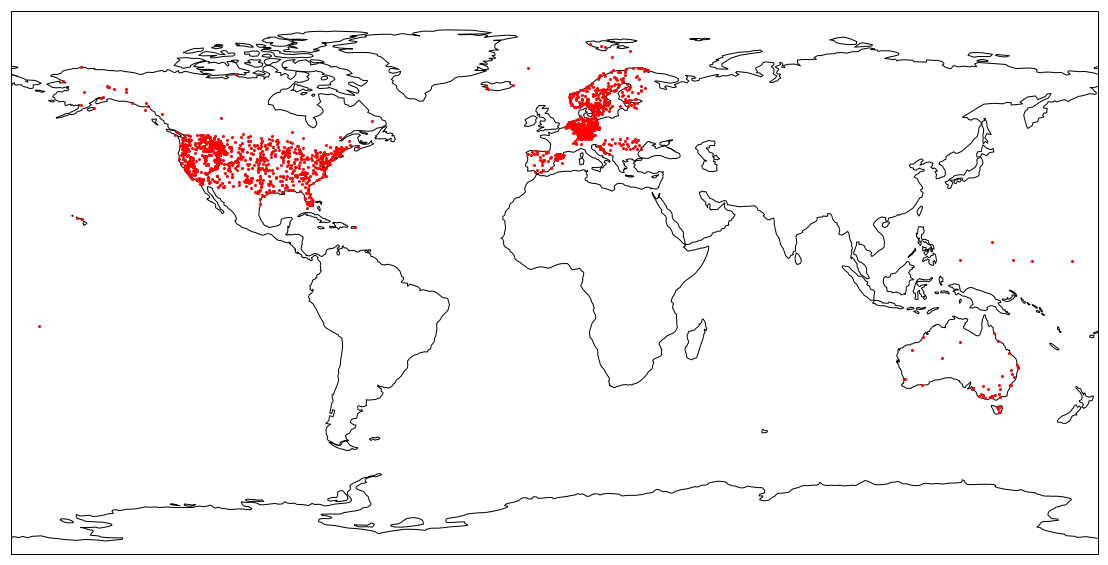

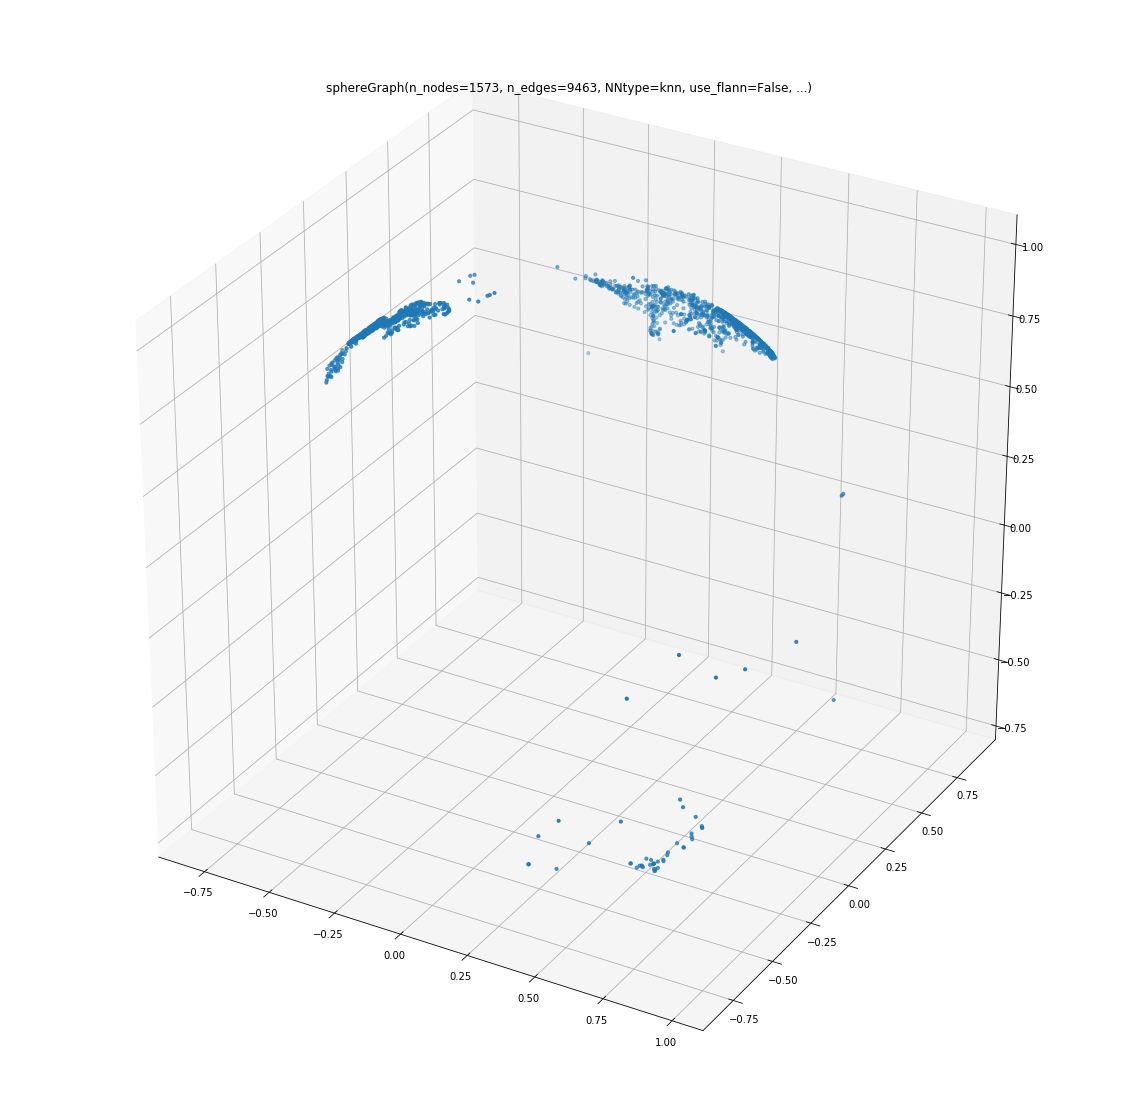

In [21]:
dataset_temp, keep_temp, gTemp = clean_nodes(full_data, [1,3], lon, lat, figs=True, rad=False)

In [22]:
min(gTemp.dw)

0.1773437757473814

(array([  5.,   5.,  12.,  42., 160., 442., 591., 255.,  59.,   2.]),
 array([ 0.17734378,  1.76577536,  3.35420694,  4.94263852,  6.5310701 ,
         8.11950168,  9.70793326, 11.29636485, 12.88479643, 14.47322801,
        16.06165959]),
 <a list of 10 Patch objects>)

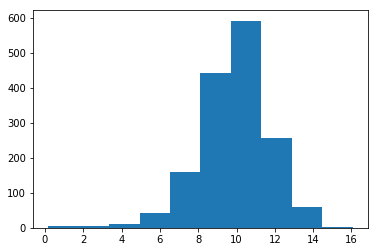

In [23]:
plt.hist(gTemp.dw, )

In [24]:
leap_years = np.zeros_like(years).astype(np.bool)
for i, in_year in enumerate(np.split(valid_days,len(years))):
    leap_years[i] = in_year.sum()==366

NameError: name 'valid_days' is not defined

In [25]:
w_months = np.tile(np.repeat(np.arange(12), 31), years[-1]-years[0]+1)[valid_days]
w_days = np.tile(np.arange(365),years[-1]-years[0]+1)
for i, leap in enumerate(leap_years):
    if leap:
        w_days = np.insert(w_days, ((i+1)*365), 365)

NameError: name 'valid_days' is not defined

In [26]:
w_days_sin = np.sin(w_days/367*np.pi)
w_days_cos = -np.cos(w_days/367*np.pi*2)/2+0.5

NameError: name 'w_days' is not defined

In [21]:
from GHCN_preprocessing import dataset_temp
training, validation = dataset_temp(datas, lon, lat, alt, w_days, add_feat=True)

NameError: name 'w_days' is not defined

In [26]:
mask = ~np.isnan(dataset[:,keepSuper,1:3])
dataset_super = dataset[:, keepSuper, 1:3] # n_days graphs of superset
gTempSuper = sphereGraph(lon[keepSuper], lat[keepSuper], neighbour, rad=False, epsilon=False)
gTempSuper.compute_laplacian("combinatorial")

In [24]:
min(gTempSuper.dw)

0.5565725090982634

(array([9.000e+00, 2.000e+00, 1.900e+01, 9.300e+01, 7.860e+02, 3.268e+03,
        3.504e+03, 1.641e+03, 3.730e+02, 3.300e+01]),
 array([ 0.55657251,  2.04774249,  3.53891247,  5.03008245,  6.52125243,
         8.01242241,  9.50359239, 10.99476237, 12.48593236, 13.97710234,
        15.46827232]),
 <a list of 10 Patch objects>)

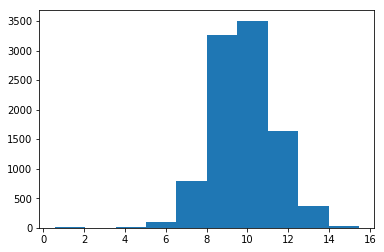

In [25]:
plt.hist(gTempSuper.dw)

In [27]:
for day in range(dataset_super.shape[0]):
    for feat in range(dataset_super.shape[-1]):
        dataset_super[day,:,feat] = regression_tikhonov(gTempSuper, dataset_super[day,:,feat], mask[day,:,feat])

In [28]:
np.isnan(dataset_super).sum()

0

In [29]:
## temp max from temp min

ratio = 0.7
n_days = dataset_temp.shape[0]
limit= int(ratio*n_days)

mean = np.nanmean(dataset[:, keepSuper, 1:3], axis=(0,1))[0]
std = np.nanstd(dataset[:, keepSuper, 1:3], axis=(0,1))[0]

x_train = (dataset_super[:limit,:,0] - mean) / std
labels_train = dataset_super[:limit,:,1]
x_val = (dataset_super[limit:,:,0] - mean) / std
labels_val = dataset_super[limit:,:,1]

x_train = np.dstack([x_train, 
                     mask[:limit, :, :]])
x_val = np.dstack([x_val, 
                   mask[limit:, :, :]])


training_super = LabeledDataset(x_train, labels_train)
validation_super = LabeledDataset(x_val, labels_val)

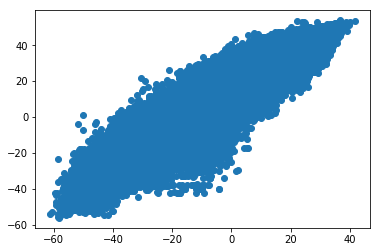

In [290]:
plt.scatter(dataset_super[:,:,0], dataset_super[:,:,1])

In [36]:
np.where(dataset_super[:,:,0]> dataset_super[:,:,1])[0]

array([   0,    1,    1, ..., 1825, 1825, 1825])

In [37]:
arg = 1825

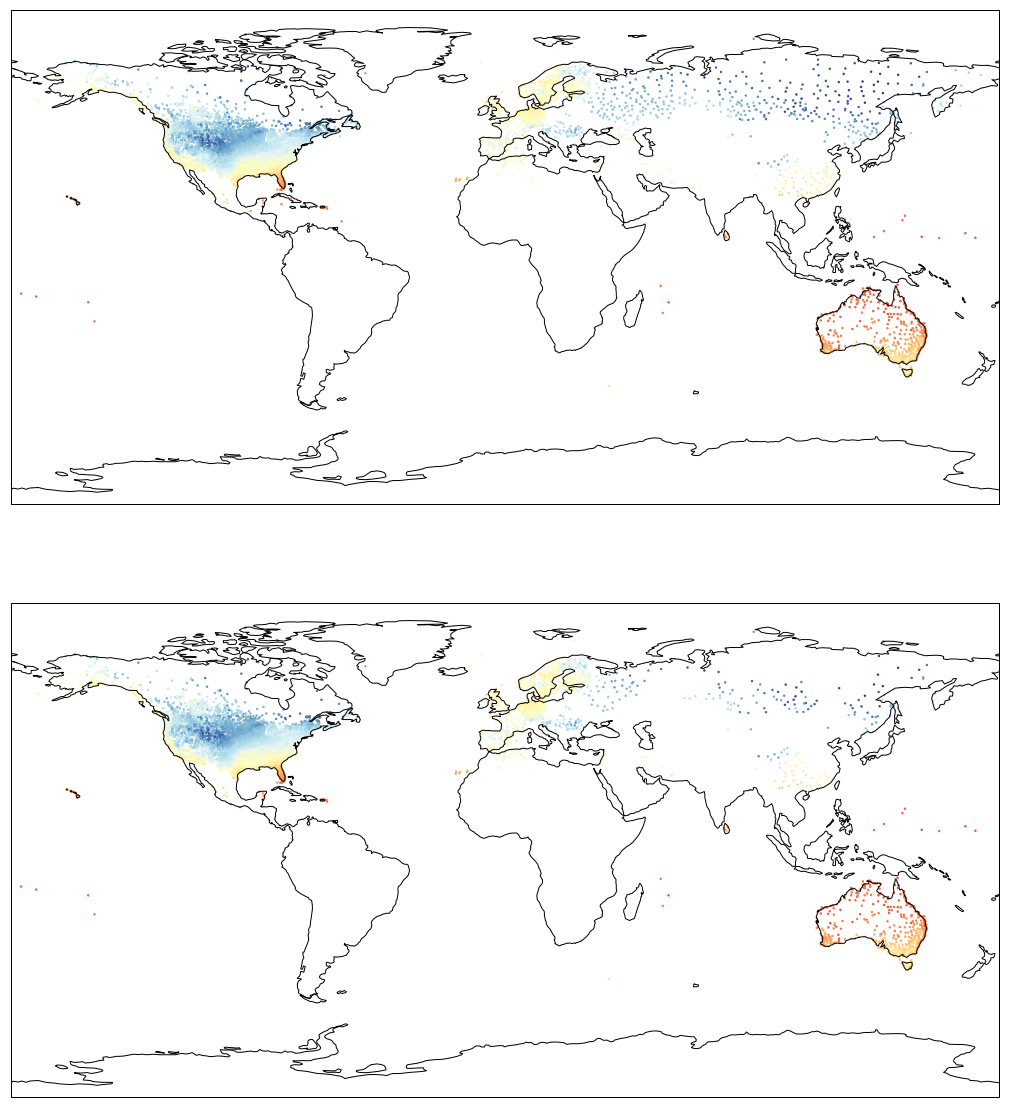

In [46]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

zmin = -40
zmax = 40


plt.scatter(lon[keepSuper], lat[keepSuper], s=2,
            c=np.clip(dataset_super[arg, :, 0], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
            vmin=zmin, vmax=zmax, alpha=1)

ax = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()


plt.scatter(lon[keepSuper], lat[keepSuper], s=2,
            c=np.clip(dataset[:, keepSuper, 1:3][arg, :, 0], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
            vmin=zmin, vmax=zmax, alpha=1)

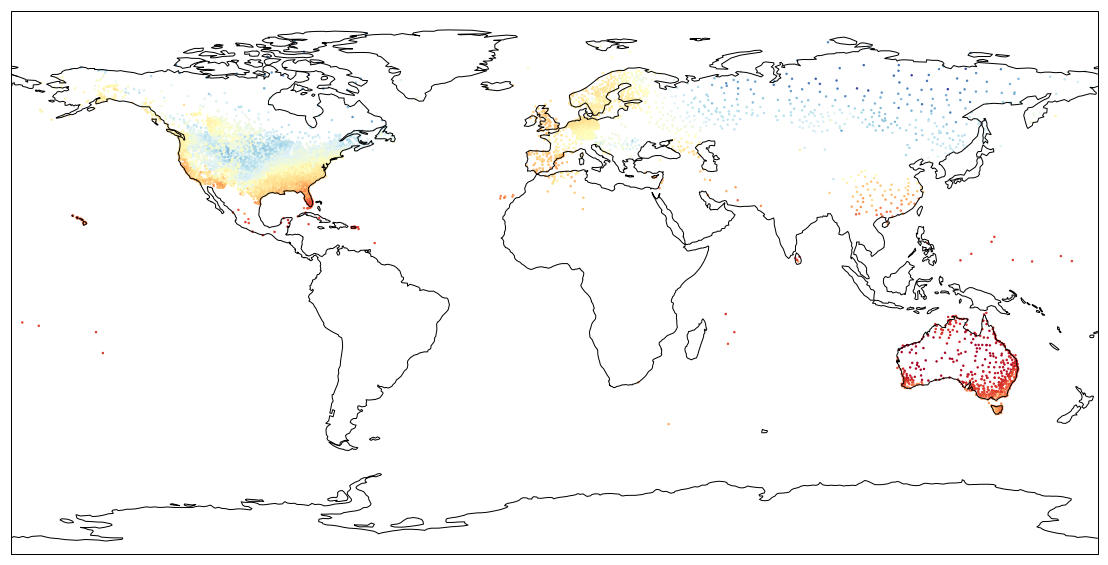

In [39]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon[keepSuper], lat[keepSuper], s=2,
            c=np.clip(dataset_super[arg, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
            vmin=zmin, vmax=zmax, alpha=1)

#### Precipirtation from temperatures (MIN, MAX)

In [205]:
dataset = full_data.transpose((1, 0, 2)).copy()
# remove outliers
### min temp is impossible
# out = np.where(dataset[:,:,1]>100)
# dataset[:,:,1][out] = np.nan

# ### min temp is always the same and max temp doesn't make sens
# out = np.where(dataset[:,:,1]<-60)
# dataset[:,:,1][out] = np.nan

# ### max temp is too big ofr the location and the min temp
# out = np.where(dataset[:,:,2]>60)
# dataset[:,:,2][out] = np.nan


# ## min is bigger than max
# out = np.where(dataset[:,:,1]>dataset[:,:,2])
# dataset[:,:,1:3][out] = np.nan

# ## dif between two days is bigger than 20° (what max is possible?)
# out = np.where(np.abs(np.diff(dataset[:,:,1:3], axis=0))>20)
# dataset[:,:,1:3][out] = np.nan
# dataset[:,:,1:3][out[0]+1,out[1], out[2]] = np.nan


keepToo = ~np.isnan(dataset[:,:,:3]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,:3])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_prec = dataset[:, keepToo, :3]

In [18]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 1085
n stations superset = 9728


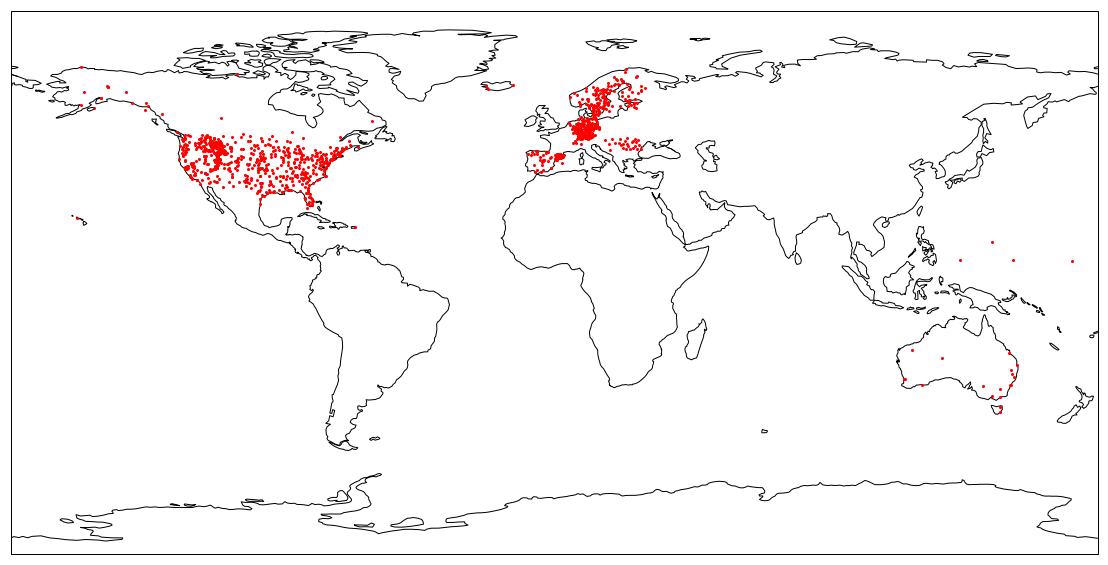

In [19]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

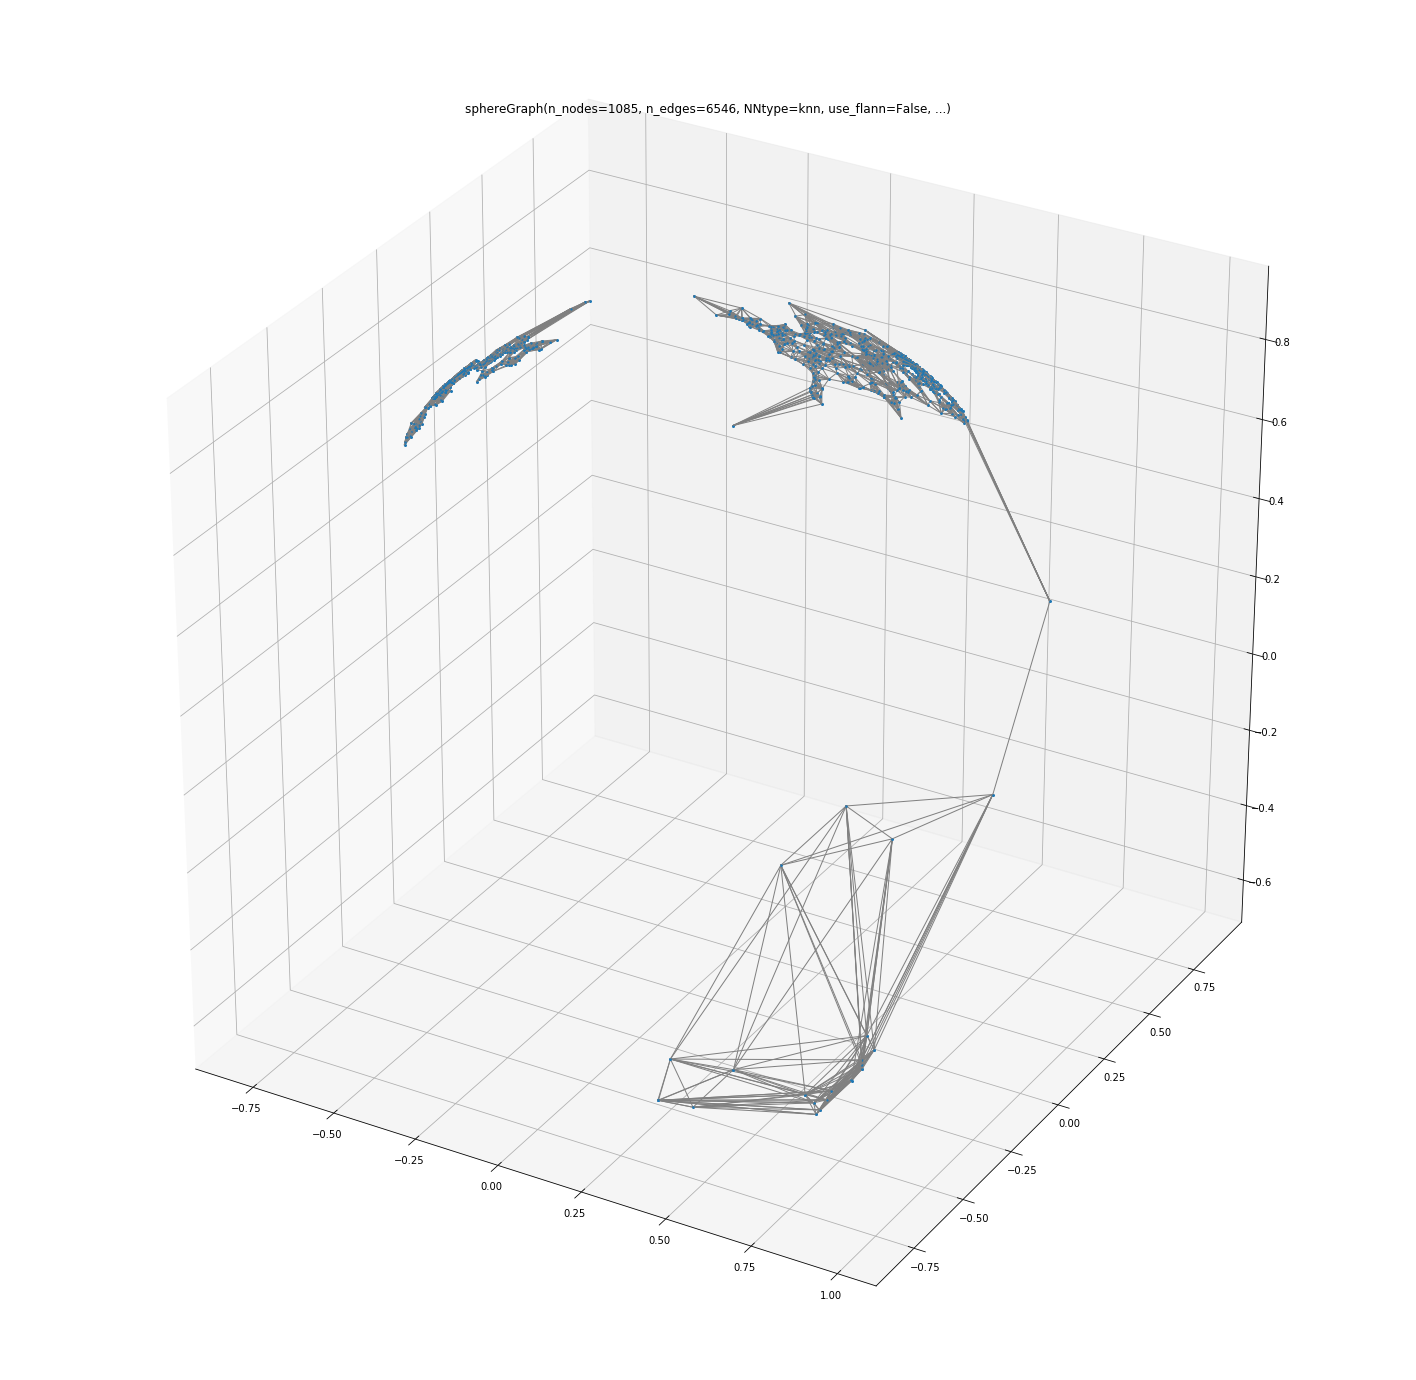

In [206]:
neighbour = 10
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gPrec = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gPrec.plot(vertex_size=10, edges=True, ax=axes)
gPrec.compute_laplacian("combinatorial")

In [24]:
## precipitation from temp

ratio = 0.7
n_days = dataset_prec.shape[0]
limit= int(ratio*n_days)

mean = dataset_prec.mean(axis=(0,1))[1:3]
std = dataset_prec.std(axis=(0,1))[1:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = (dataset_prec[:limit,:,1:3] - mean) / std
labels_train = dataset_prec[:limit,:,0]
x_val = (dataset_prec[limit:,:,1:3] - mean) / std
labels_val = dataset_prec[limit:,:,0]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(w_days_sin[:limit, np.newaxis], x_train.shape[1], axis=1)])
x_val = np.dstack([x_val, np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(w_days_sin[limit:, np.newaxis], x_val.shape[1], axis=1)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [94]:
mask = ~np.isnan(dataset[:,keepSuper,1:3])
dataset_super = dataset[:, keepSuper, 1:3] # n_days graphs of superset
gRegSuper = sphereGraph(lon[keepSuper], lat[keepSuper], neighbour, rad=False, epsilon=False)
gRegSuper.compute_laplacian("combinatorial")

2019-06-12 09:46:13,523:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [95]:
for day in range(dataset_super.shape[0]):
    for feat in range(dataset_super.shape[-1]):
        dataset_super[day,:,feat] = regression_tikhonov(gRegSuper, dataset_super[day,:,feat], mask[day,:,feat])

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [133]:
np.isnan(dataset_super).sum()

0

In [30]:
## precipitation from temp

ratio = 0.7
n_days = dataset_super.shape[0]
limit= int(ratio*n_days)

mean = dataset_super.mean(axis=(0,1))[1:3]
std = dataset_super.std(axis=(0,1))[1:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train_super = (dataset_super[:limit,:,1:3] - mean) / std
labels_train_super = dataset_super[:limit,:,0]
x_val_super = (dataset_super[limit:,:,1:3] - mean) / std
labels_val_super = dataset_super[limit:,:,0]

# location of stations
coords_v = np.stack([lon[keepSuper], lat[keepSuper]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepSuper]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train_super = np.dstack([x_train_super, np.repeat(coords_v[np.newaxis,:], x_train_super.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train_super.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train_super.shape[1], axis=1)])
x_val_super = np.dstack([x_val_super, np.repeat(coords_v[np.newaxis,:], x_val_super.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val_super.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val_super.shape[1], axis=1)])

training = LabeledDataset(x_train_super, labels_train_super)
validation = LabeledDataset(x_val_super, labels_val_super)

NameError: name 'dataset_super' is not defined

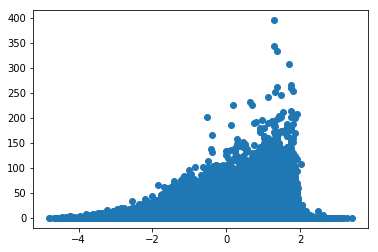

In [31]:
plt.scatter(x_train[:,:,0], labels_train)

In [32]:
plt.scatter(x_train_super[:,:,0], labels_train_super)

NameError: name 'x_train_super' is not defined

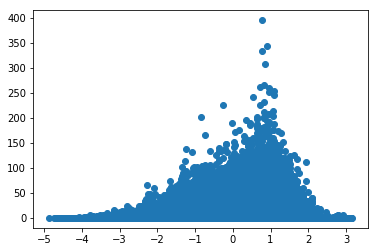

In [33]:
plt.scatter(x_train[:,:,1], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,1], labels_train_super)

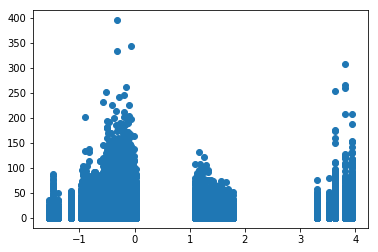

In [34]:
plt.scatter(x_train[:,:,2], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,2], labels_train_super)

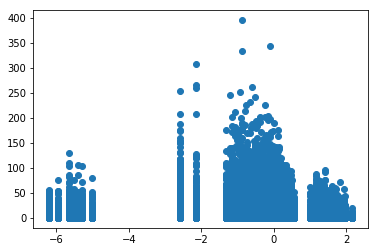

In [35]:
plt.scatter(x_train[:,:,3], labels_train)

In [ ]:
plt.scatter(x_train_super[:,:,3], labels_train_super)

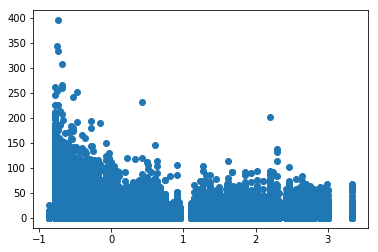

In [36]:
plt.scatter(x_train[:,:,4], labels_train)

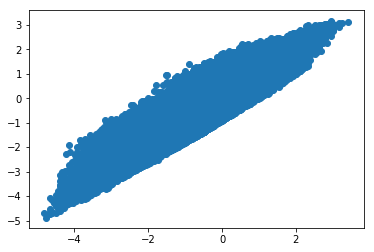

In [37]:
plt.scatter(x_train[:,:,0], x_train[:,:,1])

In [ ]:
plt.scatter(x_train_super[:,:,0], x_train_super[:,:,1])

In [38]:
time = np.empty_like(x_train[:,:,0])
time[:,:] = np.arange(time.shape[0])[:,np.newaxis]

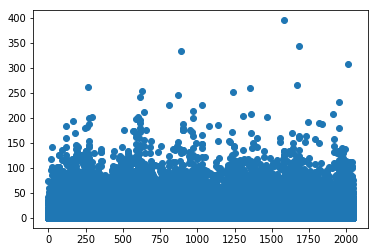

In [39]:
plt.scatter(time, labels_train)

#### future temperature to find, regression

In [138]:
dataset = full_data.transpose((1, 0, 2)).copy()
# # remove outliers
# ### min temp is impossible
# out = np.where(dataset[:,:,1]>100)
# dataset[:,:,1][out] = np.nan

# ### min temp is always the same and max temp doesn't make sens
# out = np.where(dataset[:,:,1]<-60)
# dataset[:,:,1][out] = np.nan

# ### max temp is too big ofr the location and the min temp
# out = np.where(dataset[:,:,2]>=60)
# dataset[:,:,2][out] = np.nan

# ## series of exact same values for the same location. seems strange
# out = np.where((dataset[:,:,1]==-35.6)*(dataset[:,:,2]>0))
# dataset[:,:,1][out] = np.nan

# ## min is bigger than max
# out = np.where(dataset[:,:,1]>dataset[:,:,2])
# dataset[:,:,1:3][out] = np.nan

# ## dif between two days is bigger than 20° (what max is possible)
# out = np.where(np.abs(np.diff(dataset[:,:,1:3], axis=0))>20)
# dataset[:,:,1:3][out] = np.nan
# dataset[:,:,1:3][out[0]+1,out[1], out[2]] = np.nan


keepToo = ~np.isnan(dataset[:,:,1:3]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,1:3])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_temp_reg = dataset[:, keepToo, 1:3]

In [110]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 1573
n stations superset = 11996


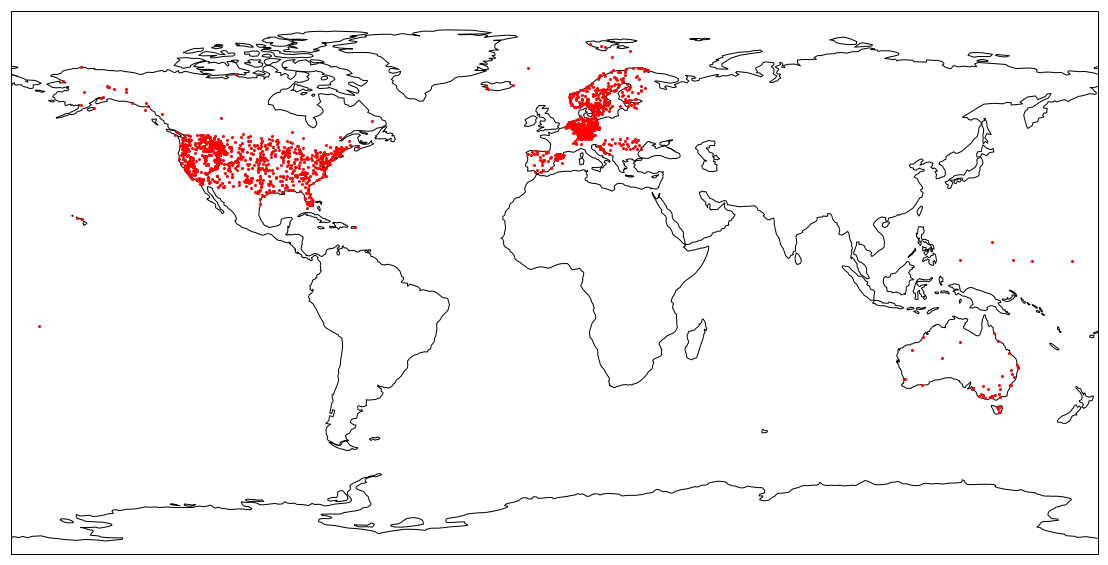

In [111]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

In [51]:
us_lat = np.where(lat[keepToo]>0)
us = [np.where(np.logical_or(lon[keepToo][us_lat]<-30, 0))]

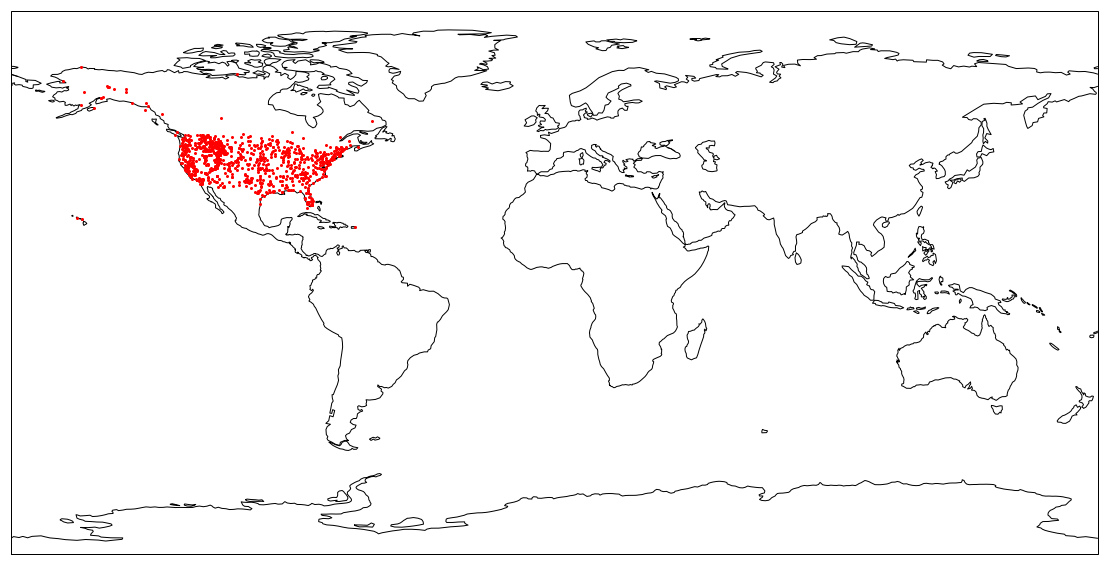

In [52]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

tmp = plt.plot(lon[keepToo][us_lat][us], lat[keepToo][us_lat][us], 'or', marker='o', markerfacecolor='r', markersize=2)

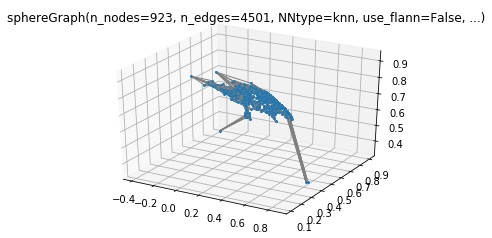

In [53]:
neighbour = 8
gReg = sphereGraph(lon[keepToo][us_lat][us], lat[keepToo][us_lat][us], neighbour, rad=False, epsilon=False)
gReg.plot(vertex_size=10, edges=True)

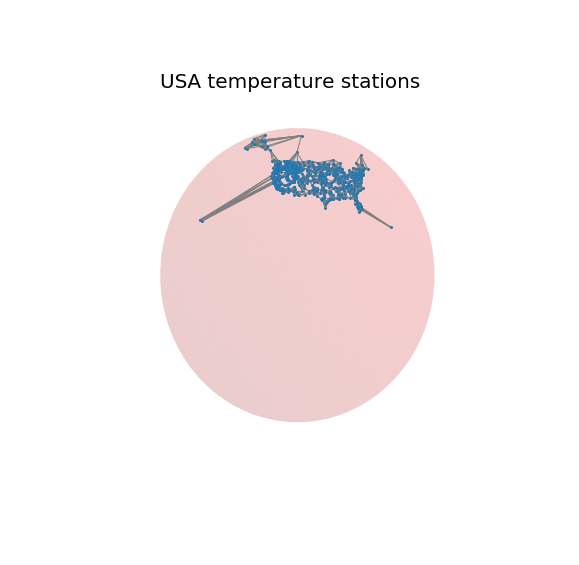

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# gReg = sphereGraph(lon[keepToo][us_lat][us], lat[keepToo][us_lat][us], neighbour, rad=False, epsilon=False)
gReg.plot(vertex_size=10, edges=True, ax=ax)
ax.set_title('USA temperature stations', fontsize=20)
ax.view_init(elev=0, azim=70)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.axis('off')

u, v = np.mgrid[0:2*np.pi:80j, 0:np.pi:40j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, color="r", alpha=0.1)

plt.savefig(pathfig+"USA_temp.svg", bboxes_inches='tight')

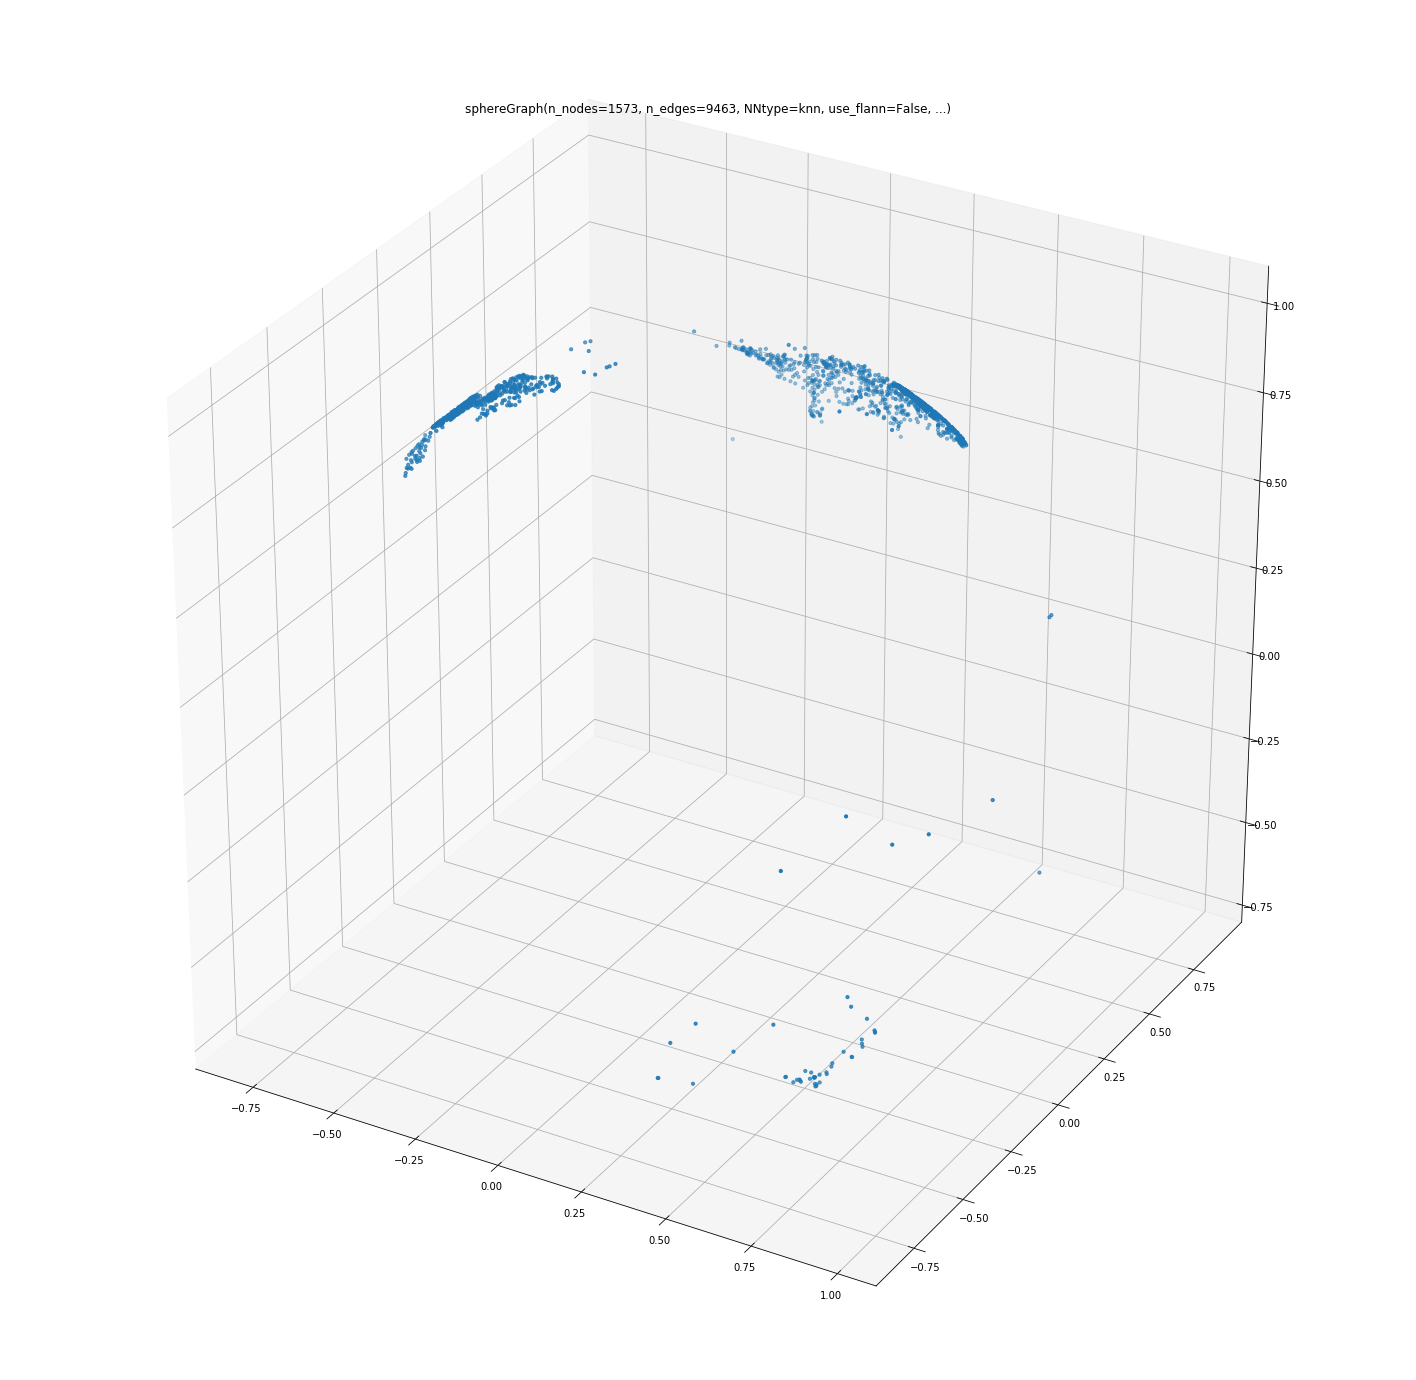

In [48]:
neighbour = 10
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gReg = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gReg.plot(vertex_size=10, edges=False, ax=axes)
gReg.compute_laplacian("combinatorial")

In [27]:
w_days_sin = np.sin(w_days/367*np.pi)

In [59]:
x_train.shape

(2548, 1573, 5)

In [61]:
## temp future (regression)
days_pred = 5

n_days, n_stations, n_feature= dataset_temp_reg.shape

dataset_x = np.vstack([np.roll(dataset_temp_reg, -i, axis=0) for i in range(days_pred)])
dataset_x = dataset_x.reshape(days_pred, n_days, n_stations, n_feature).transpose((1,2,3,0))

# mean_x = dataset_x.mean(axis=(0,1))
# std_x = dataset_x.std(axis=(0,1))

# month_x = np.vstack([np.roll(w_months, -i, axis=0) for i in range(days_pred)])
# month_x = month_x.reshape(days_pred, n_days).transpose()

days_x = np.vstack([np.roll(w_days_sin, -i, axis=0) for i in range(days_pred)])
days_x = days_x.reshape(days_pred, n_days).transpose()

limit = int(0.7*(n_days-days_pred))

x_train = dataset_x[:limit,:,:,:].transpose(0, 2, 1, 3).reshape(-1, n_stations, days_pred)
labels_train = dataset_temp_reg[days_pred:limit+days_pred,:,:].transpose(0,2,1).reshape(-1, n_stations)
x_val = dataset_x[limit:n_days-days_pred,:,:,:].transpose(0, 2, 1, 3).reshape(-1, n_stations, days_pred)
labels_val = dataset_temp_reg[days_pred+limit:,:,:].transpose(0,2,1).reshape(-1, n_stations)

# x_train = (x_train-mean_x[0])/std_x[0]
# x_val = (x_val-mean_x[1])/std_x[1]

# location of stations
coords_v = np.stack([lon[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

# can include information on which period we are? month?
# x_train = np.dstack([x_train, 
#                     np.broadcast_to(month_x[:n_days-days_pred,np.newaxis, :], x_train.shape),
#                      np.repeat(coords_v[np.newaxis,:], x_train.shape[0],axis=0),
#                      np.repeat(alt_v[np.newaxis,:], x_train.shape[0],axis=0),
#                      np.tile(np.repeat(w_days_sin[:limit, np.newaxis], x_train.shape[1],axis=1), (2,1))])
#                      np.broadcast_to(days_x[:n_days-days_pred,np.newaxis, :], x_train.shape)])
                     
# x_val = np.dstack([x_val, 
#                   np.broadcast_to(month_x[:n_days-days_pred,np.newaxis, :], x_val.shape), 
#                    np.repeat(coords_v[np.newaxis,:], x_val.shape[0],axis=0),
#                    np.repeat(alt_v[np.newaxis,:], x_val.shape[0],axis=0),
#                    np.tile(np.repeat(w_days_sin[limit:n_days-days_pred, np.newaxis], x_val.shape[1],axis=1), (2,1))])
#                    np.broadcast_to(days_x[:n_days-days_pred,np.newaxis, :], x_val.shape)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

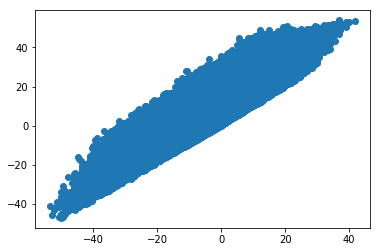

In [143]:
plt.scatter(dataset_temp_reg[:,:,0], dataset_temp_reg[:,:,1])

In [132]:
np.unravel_index(np.argmax(dataset_temp_reg), dataset_temp_reg.shape)

(1277, 672, 1)

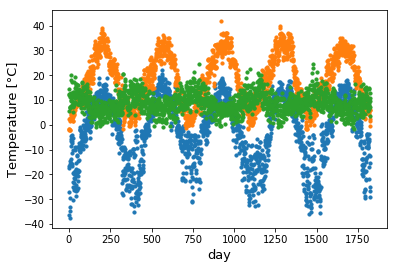

In [144]:
timereg = np.empty_like(dataset_temp_reg[:,:,0])
timereg[:,:] = np.arange(timereg.shape[0])[:,np.newaxis]
plt.scatter(timereg[:,50], dataset_temp_reg[:,50,0], s=10)
plt.scatter(timereg[:,0], dataset_temp_reg[:,672,0], s=10)
plt.scatter(timereg[:,10], dataset_temp_reg[:,10,0], s=10)
plt.xlabel('day', fontsize=13)
plt.ylabel('Temperature [°C]', fontsize=13)
plt.savefig(pathfig+'evolution_temp.png', bboxes_inches='tight')

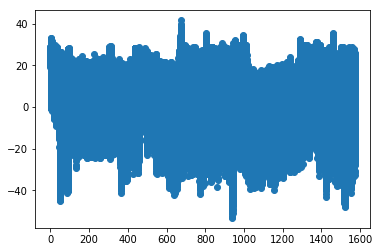

In [30]:
placereg = np.empty_like(dataset_temp_reg[:,:,0])
placereg[:,:] = np.arange(placereg.shape[1])
plt.scatter(placereg, dataset_temp_reg[:,:,0])

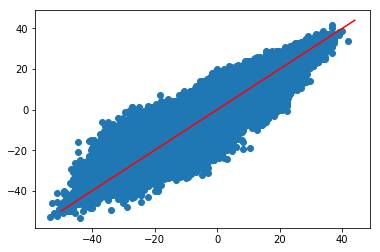

In [148]:
## is it possible to have a difference of 40 degrees between 1 day?  (must fix to +- 30 degrees)
plt.scatter(x_train[:,:,days_pred-1], labels_train)
plt.plot(range(-50, 45), range(-50, 45),'r')

#### dense-classification, segmentation weather types

In [47]:
dataset = full_data.transpose((1, 0, 2)).copy()

keep = ~np.isnan(dataset[:,:,np.array([-1])]).all(axis=0)[:,0]
dataset = dataset[:,keep,:]
keep_days = ~np.isnan(dataset[:,:,-1]).all(axis=1)
dataset = dataset[keep_days,:,:]

keepToo = ~np.isnan(dataset[:,:,np.array([-1])]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,np.array([-1])])).sum(axis=0)>0.25*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_seg = dataset[:, keepSuper, :]

In [48]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 0
n stations superset = 978


{'boxes': [<matplotlib.lines.Line2D at 0x7f8777ab00b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8777ab0ac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8777aba780>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8777aba358>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8777ab0208>,
  <matplotlib.lines.Line2D at 0x7f8777ac0438>]}

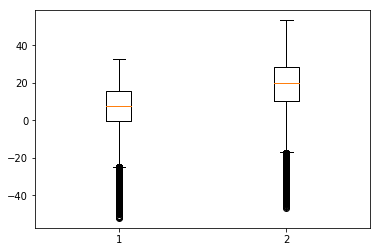

In [68]:
filt_data = []
for i in range(1,3):
    filt_data.append(dataset_seg[:,:,i][~np.isnan(dataset_seg[:,:,i])].flatten())
plt.boxplot(filt_data)

In [ ]:
dict_label = {1: 'fog', 2: 'heavy fog', 3: 'thunder', 4: 'ice pellets', 5: 'hail', 6: 'rime ice', 7: 'volcanic ash',
              8: 'smoke', 9: 'blowing snow', 10: 'tornado', 11: 'high winds', 12: 'blowing spray', 13: 'mist',
              14: 'drizzle', 15: 'freezing drizzle', 16: 'rain', 17: 'freezing rain', 18: 'snow', 19: 'unkown prec',
              21: 'ground fog', 22: 'ice fog'}

In [79]:
fog = dataset_seg[np.where(dataset_seg[:,:,-1]==4)]

{'boxes': [<matplotlib.lines.Line2D at 0x7f8777823f28>,
 'caps': [<matplotlib.lines.Line2D at 0x7f877782a978>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8777835630>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8777835208>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f877782a0b8>,
  <matplotlib.lines.Line2D at 0x7f877783d2e8>]}

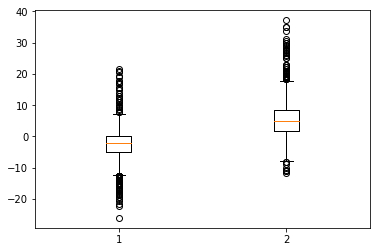

In [80]:
filt_fog = []
for i in range(1,3):
    filt_fog.append(fog[:,i][~np.isnan(fog[:,i])])
plt.boxplot(filt_fog)

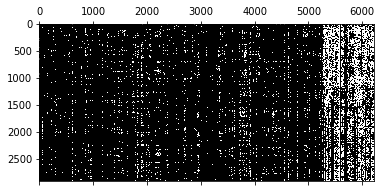

In [45]:
plt.spy(np.isnan(dataset[:,:,-1]))

#### snow prevision

In [15]:
dataset = full_data.transpose((1, 0, 2)).copy()

keepToo = ~np.isnan(dataset[:,:,:5]).any(axis=0)
keepSuper = ((~np.isnan(dataset[:,:,:5])).sum(axis=0)>0.75*dataset.shape[0])
keepToo = keepToo.all(axis=1)
keepSuper = keepSuper.all(axis=1)
dataset_snow = dataset[:, keepToo, :5]

In [16]:
print("n stations minset = {}".format(keepToo.sum()))
print("n stations superset = {}".format(keepSuper.sum()))

n stations minset = 167
n stations superset = 2439


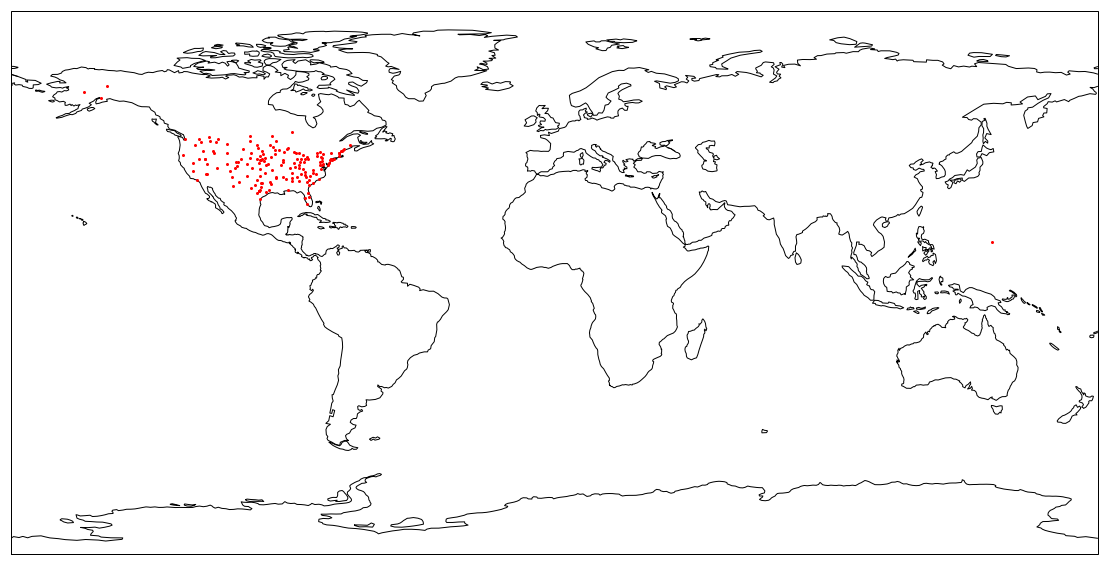

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.plot(lon[keepToo], lat[keepToo], 'or', marker='o', markerfacecolor='r', markersize=2)

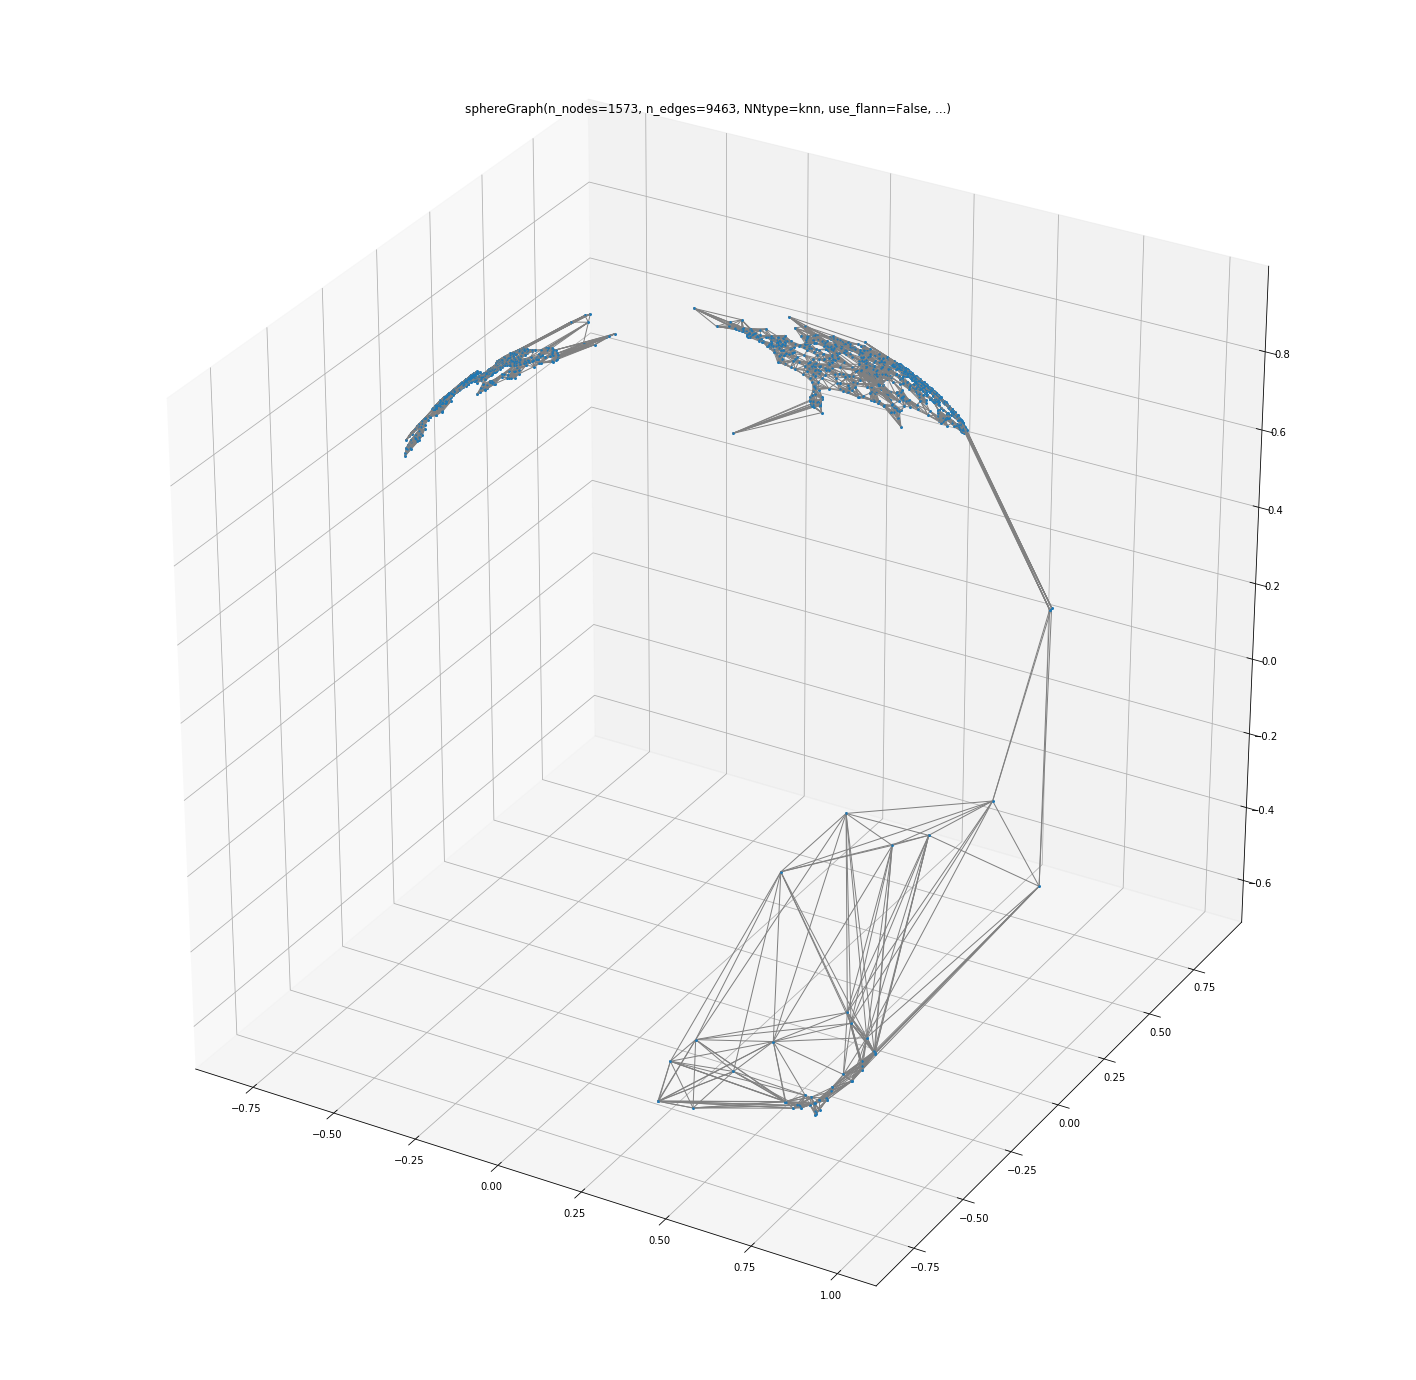

In [200]:
neighbour = 10
fig = plt.figure(figsize=(25,25))
axes = fig.add_subplot(111, projection='3d')
gSnow = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gSnow.plot(vertex_size=10, edges=True, ax=axes)
gSnow.compute_laplacian("normalized")

In [20]:
gSnow = sphereGraph(lon[keepToo], lat[keepToo], neighbour, rad=False, epsilon=False)
gSnow.compute_laplacian("combinatorial")

In [88]:
## snow from others

ratio = 0.7
n_days = dataset_snow.shape[0]
limit= int(ratio*n_days)

mean = dataset_snow.mean(axis=(0,1))[:3]
std = dataset_snow.std(axis=(0,1))[:3]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = (dataset_snow[:limit,:,:3] - mean) / std
labels_train = dataset_snow[:limit,:,3]
labels_train2 = dataset_snow[:limit,:,4]
x_val = (dataset_snow[limit:,:,:3] - mean) / std
labels_val = dataset_snow[limit:,:,3]
labels_val2 = dataset_snow[limit:,:,4]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, (np.roll(labels_train, -1, axis=0)-labels_train.mean(axis=(0,1)))/labels_train.std(axis=(0,1)), 
                     np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train.shape[1], axis=1)])
x_val = np.dstack([x_val,  (np.roll(labels_val, -1, axis=0)-labels_val.mean(axis=(0,1)))/labels_val.std(axis=(0,1)), 
                   np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val.shape[1], axis=1)])

<

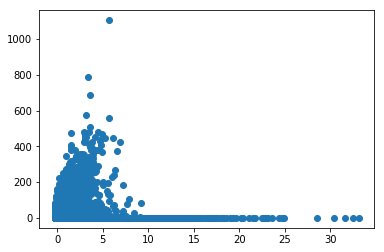

In [195]:
plt.scatter(x_train[:,:,0], labels_train)

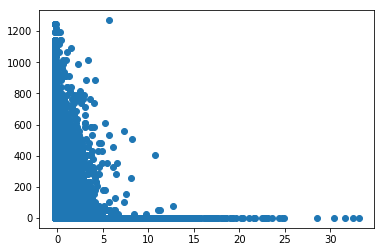

In [196]:
plt.scatter(x_train[:,:,0], labels_train2)

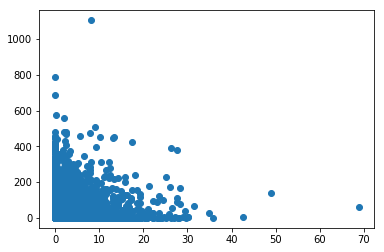

In [268]:
plt.scatter(x_train[:,:,3], labels_train)

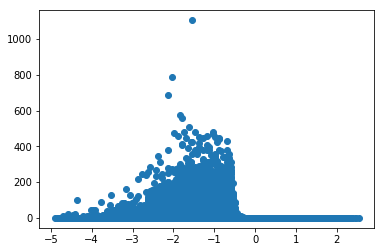

In [197]:
plt.scatter(x_train[:,:,1], labels_train)

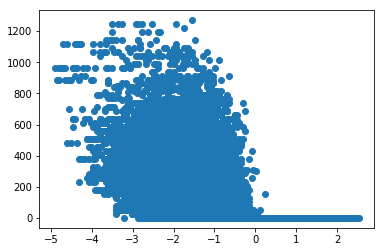

In [198]:
plt.scatter(x_train[:,:,1], labels_train2)

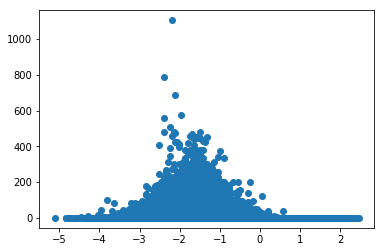

In [199]:
plt.scatter(x_train[:,:,2], labels_train)

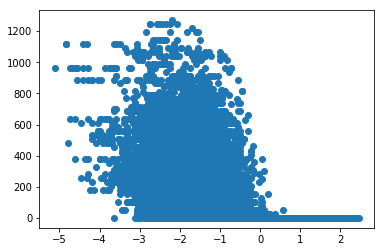

In [200]:
plt.scatter(x_train[:,:,2], labels_train2)

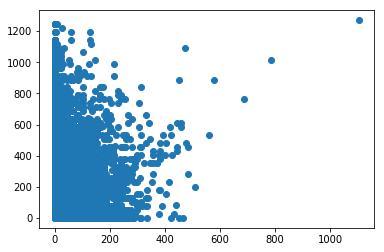

In [201]:
plt.scatter(labels_train, labels_train2)

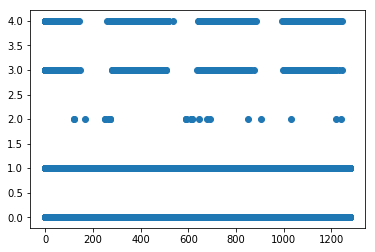

In [198]:
timesnow = np.empty_like(labels_train)
timesnow[:,:] = np.arange(timesnow.shape[0])[:,np.newaxis]
plt.scatter(timesnow, labels_train)

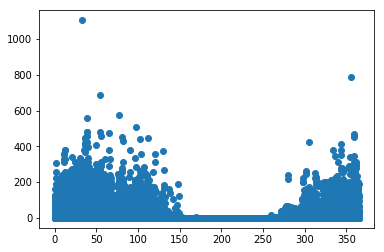

In [197]:
plt.scatter(np.broadcast_to(w_days[:limit, np.newaxis], labels_train.shape), labels_train)

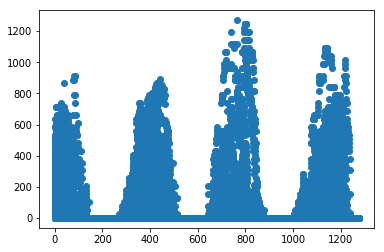

In [204]:
plt.scatter(timesnow, labels_train2)

### segmentation ourselves

In [21]:
# labels 0: normal, 1: rain (>5), ?: heavy rain (>200), 2: snow (>5), ?: heavy snow( > 1000), ?: snow and rain
labels = np.zeros((dataset_snow.shape[0], dataset_snow.shape[1], 3), dtype=np.bool)
labels[:,:,1] = (dataset_snow[:,:,0]>1) * (dataset_snow[:,:,3]<=1) # * (dataset_snow[:,:,0]<=150)
#labels[:,:,2] = dataset_snow[:,:,0]>150
labels[:,:,2] = (dataset_snow[:,:,3]>1)# * (dataset_snow[:,:,3]<=400)
# labels[:,:,4] = dataset_snow[:,:,3]>400
labels[:,:,0] = ~labels.any(axis=2)
#labels[:,:,4] = labels[:,:,1] * labels[:,:,3]
#labels[labels[:,:,4]] = [False]*4 + [True]

In [22]:
labels.sum(axis=(0,1))

array([234344,  53271,  17327])

In [23]:
labels[np.where(labels.sum(axis=2)>1)].sum(axis=0)

array([0, 0, 0])

In [24]:
labels = np.argmax(labels, axis=-1)

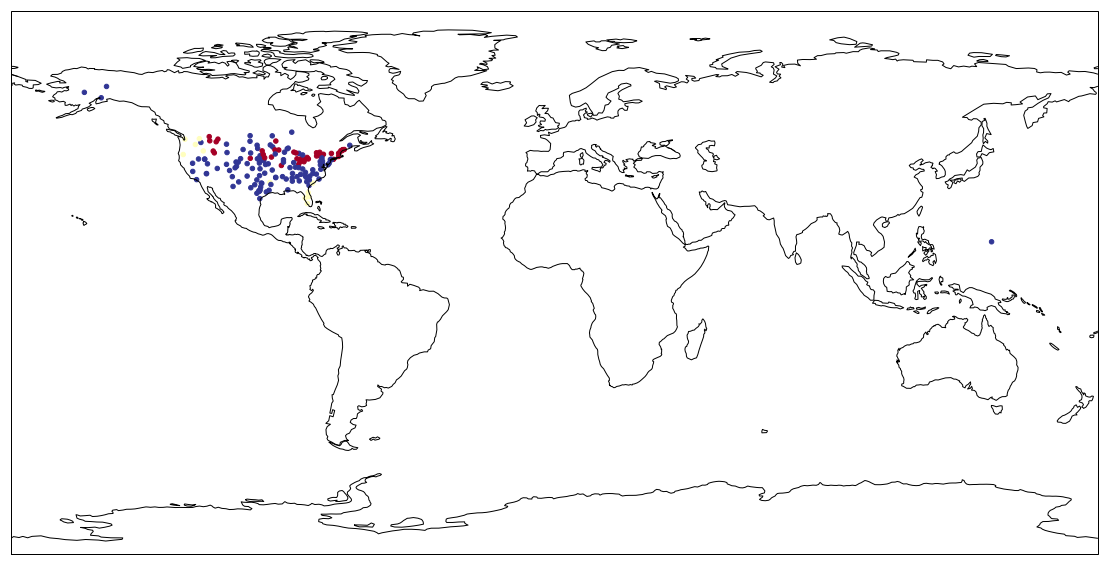

In [25]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon[keepToo], lat[keepToo], s=20,
            c=labels[0, :], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [29]:
## snow from others

ratio = 0.7
n_days = dataset_snow.shape[0]
limit= int(ratio*n_days)

mean = dataset_snow.mean(axis=(0,1))[:4]
std = dataset_snow.std(axis=(0,1))[:4]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = (dataset_snow[:limit,:,:4] - mean) / std
labels_train = labels[:limit,:]
x_val = (dataset_snow[limit:,:,:4] - mean) / std
labels_val = labels[limit:,:]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, 
                     np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(w_days[:limit, np.newaxis], x_train.shape[1], axis=1)])
x_val = np.dstack([x_val,
                   np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(w_days[limit:, np.newaxis], x_val.shape[1], axis=1)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [30]:
for i in range(5):
    print(len(np.where(labels_train==i)[0]), len(np.where(labels_val==i)[0]))

164379 69965
36904 16367
12143 5184
0 0
0 0


### Global regression task

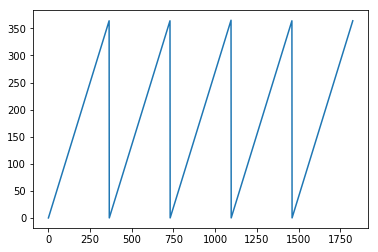

In [35]:
plt.plot(w_days)

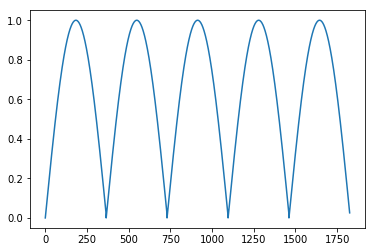

In [36]:
plt.plot(w_days_sin)

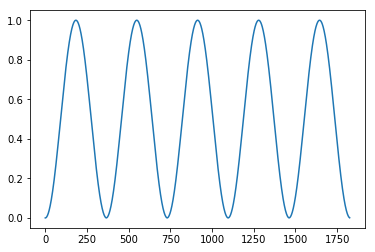

In [26]:
plt.plot(w_days_cos)

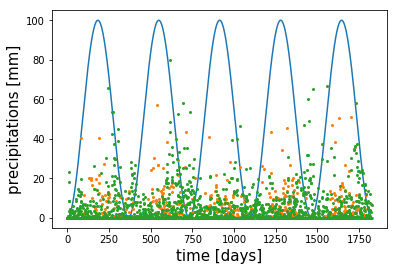

In [64]:
plt.plot(w_days_cos*100)
plt.plot(dataset_prec[:,2,0], 'o', markersize=2)
plt.plot(dataset_prec[:,20,0], 'o', markersize=2)
plt.ylabel('precipitations [mm]', fontsize=15)
plt.xlabel('time [days]', fontsize=15)
# plt.plot(dataset_prec[:,100,0], 'o', markersize=2)
plt.savefig(pathfig+'prec_time.png', bboxes_inches='tight')

In [213]:
## precipitation from temp

ratio = 0.7
n_days = dataset_prec.shape[0]
limit= int(ratio*n_days)

mean = dataset_prec.mean(axis=(0,1))[0]
std = dataset_prec.std(axis=(0,1))[0]
# mean_label = dataset_prec.mean(axis=(0,1))[0]
# std_label = dataset_prec.std(axis=(0,1))[0]

x_train = np.atleast_3d((dataset_prec[:limit,:,:] - mean) / std)
labels_train = w_days_cos[:limit]
x_val = np.atleast_3d((dataset_prec[limit:,:,:] - mean) / std)
labels_val = w_days_cos[limit:]

# location of stations
coords_v = np.stack([lon[keepToo], lat[keepToo]], axis=-1)
coords_v = (coords_v-coords_v.mean(axis=0))/coords_v.std(axis=0)
# altitude of stations
alt_v = elev[keepToo]
alt_v = (alt_v-alt_v.mean())/alt_v.std()

x_train = np.dstack([x_train, np.repeat(coords_v[np.newaxis,:], x_train.shape[0], axis=0),
                     np.repeat(alt_v[np.newaxis,:], x_train.shape[0], axis=0)])
x_val = np.dstack([x_val, np.repeat(coords_v[np.newaxis,:], x_val.shape[0], axis=0),
                  np.repeat(alt_v[np.newaxis,:], x_val.shape[0], axis=0)])

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

## training

In [24]:
import tensorflow as tf
params = {'L': [gPrec.L.astype(np.float32)]*4,
          'p': [1,1,1,1],
          'F': [50, 100, 100, 1],#np.max(labels_train)+1],
          'K': [5]*4,
          'batch_norm': [True]*4}
# EXP_NAME = params['dir_name'] = 'GHCN_future_nothing_{}days_{}neighbours_K{}_less_random'.format(days_pred, neighbour, params['K'][0])
EXP_NAME = params['dir_name'] = 'GHCN_Prec_{}neighbours_K{}_less_random'.format(neighbour, params['K'][0])
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 250  # Number of passes through the training data.
params['batch_size'] = 64
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations =250
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['regression']=True
#params['mask'] = [mask[:limit,:,1], mask[limit:,:,1]]
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 1085
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1085 * 50 / 1 = 54250
    weights: F_0 * F_1 * K_1 = 6 * 50 * 5 = 1500
    biases: F_1 = 50
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1085 * 100 / 1 = 108500
    weights: F_1 * F_2 * K_2 = 50 * 100 * 5 = 25000
    biases: F_2 = 100
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 1085 * 100 / 1 = 108500
    weights: F_2 * F_3 * K_3 = 100 * 100 * 5 = 50000
    biases: F_3 = 100
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 1085 * 1 / 1 = 1085
    weights: F_3 * F_4 * K_4 = 100 * 1 * 5 = 500
    batch normalization


In [214]:
import tensorflow as tf
params = {'L': [gPrec.L.astype(np.float32)]*3,
          'p': [1,1,1],
          'F': [50, 100, 100],#np.max(labels_train)+1],
          'K': [5]*3,
          'batch_norm': [True]*3}
EXP_NAME = params['dir_name'] = 'GHCN_global_reg_cos_{}neighbours_K{}'.format(neighbour, params['K'][0])
params['num_feat_in'] = x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'max'
params['activation'] = 'relu'
params['statistics'] = 'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 250  # Number of passes through the training data.
params['batch_size'] = 64
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations =250
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = [1]
params['regression']=True
#params['mask'] = [mask[:limit,:,1], mask[limit:,:,1]]
model = models.cgcnn(**params)

NN architecture
  input: M_0 = 1085
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1085 * 50 / 1 = 54250
    weights: F_0 * F_1 * K_1 = 6 * 50 * 5 = 1500
    biases: F_1 = 50
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1085 * 100 / 1 = 108500
    weights: F_1 * F_2 * K_2 = 50 * 100 * 5 = 25000
    biases: F_2 = 100
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 1085 * 100 / 1 = 108500
    weights: F_2 * F_3 * K_3 = 100 * 100 * 5 = 50000
    biases: F_3 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 4: logits (softmax)
    representation: M_4 = 1
    weights: M_3 * M_4 = 100 * 1 = 100


In [66]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

NN architecture
  input: M_0 = 167
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 167 * 20 / 1 = 3340
    weights: F_0 * F_1 * K_1 = 6 * 20 * 10 = 1200
    biases: F_1 = 20
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 167 * 50 / 1 = 8350
    weights: F_1 * F_2 * K_2 = 20 * 50 * 10 = 10000
    biases: F_2 = 50
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 167 * 80 / 1 = 13360
    weights: F_2 * F_3 * K_3 = 50 * 80 * 10 = 40000
    biases: F_3 = 80
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 167 * 100 / 1 = 16700
    weights: F_3 * F_4 * K_4 = 80 * 100 * 10 = 80000
    biases: F_4 = 100
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 167 * 100 / 1 = 16700
    weights: F_4 * F_5 * K_5 = 100 * 100 * 10 = 100000
    biases: F_5 = 100
    batch normalization
  layer 6: cgconv6
    representation: M_5 * F_6 / p_6 = 167 * 5 / 1 = 835
    weights

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 27.13 (24832 / 91516), f1 (weighted): 29.47, loss: 1.60e+00
  CPU time: 6s, wall time: 6s, perf_time_load: 0.133s, perf_time: 0.000s
step 18 / 399 (epoch 0.90 / 20):
  learning_rate = 2.75e-06, training accuracy = 0.00, training loss = 1.65e+00
  validation accuracy: 27.29 (24977 / 91516), f1 (weighted): 33.05, loss: 1.72e+00
  CPU time: 9s, wall time: 10s, perf_time_load: 0.133s, perf_time: 0.000s
step 27 / 399 (epoch 1.35 / 20):
  learning_rate = 4.61e-06, training accuracy = 0.28, training loss = 1.60e+00
  validation accuracy: 23.53 (21534 / 91516), f1 (weighted): 30.11, loss: 1.77e+00
  CPU time: 10s, wall time: 12s, perf_time_load: 0.133s, perf_time: 0.000s
step 36 / 399 (epoch 1.80 / 20):
  learning_rate = 7.76e-06, training accuracy = 0.28, training loss = 1.54e+00
  validation accuracy: 25.04 (22914 / 91516), f1 (weighted): 32.31, loss: 1.71e+00
  CPU time: 13s, wall time: 15s, perf_time_load: 0.134s, perf_time: 0.000s
step 45 / 399 (epoch 2.25 / 20):
  

step 288 / 399 (epoch 14.42 / 20):
  learning_rate = 1.61e+01, training accuracy = 0.64, training loss = 9.54e+02
  validation accuracy: 3.34 (3056 / 91516), f1 (weighted): 0.22, loss: 8.90e+04
  CPU time: 60s, wall time: 78s, perf_time_load: 0.134s, perf_time: 0.000s
step 297 / 399 (epoch 14.87 / 20):
  learning_rate = 2.70e+01, training accuracy = 0.64, training loss = 1.61e+00
  validation accuracy: 52.40 (47951 / 91516), f1 (weighted): 54.91, loss: 7.90e+02
  CPU time: 62s, wall time: 81s, perf_time_load: 0.135s, perf_time: 0.000s
step 306 / 399 (epoch 15.32 / 20):
  learning_rate = 4.54e+01, training accuracy = 0.64, training loss = 1.61e+00
  validation accuracy: 75.44 (69039 / 91516), f1 (weighted): 66.15, loss: 6.46e+00
  CPU time: 64s, wall time: 83s, perf_time_load: 0.134s, perf_time: 0.000s
step 315 / 399 (epoch 15.77 / 20):
  learning_rate = 7.62e+01, training accuracy = 0.64, training loss = 1.61e+00
  validation accuracy: 76.45 (69965 / 91516), f1 (weighted): 66.25, loss:

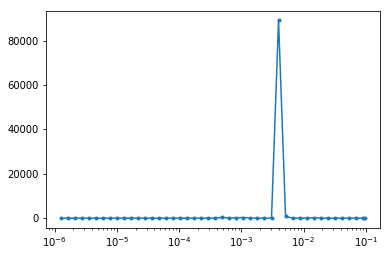

In [250]:
from deepsphere.utils import test_learning_rates
backup = params.copy()

params, learning_rate = test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.cgcnn(**params)
_, loss_validation, _, _, _ = model.fit(training, validation)

params.update(backup)
model = models.cgcnn(**params)
plt.semilogx(learning_rate, loss_validation, '.-')

In [251]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

In [74]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(training, validation)

step 19 / 4992 (epoch 0.95 / 250):
  learning_rate = 1.00e-03, training mean relative error = 3.21e-01, training loss = 1.27e-01
  validation explained variance: 0.1540, r2: -0.3239, loss (MSE): 1.662e-01, loss (MAE): 3.367e-01
  CPU time: 3s, wall time: 6s, perf_time_load: 0.242s, perf_time: 0.242s
step 38 / 4992 (epoch 1.90 / 250):
  learning_rate = 1.00e-03, training mean relative error = 2.82e-01, training loss = 9.28e-02
  validation explained variance: 0.2467, r2: 0.2365, loss (MSE): 9.746e-02, loss (MAE): 2.680e-01
  CPU time: 6s, wall time: 12s, perf_time_load: 0.199s, perf_time: 0.199s
step 57 / 4992 (epoch 2.85 / 250):
  learning_rate = 1.00e-03, training mean relative error = 2.60e-01, training loss = 7.72e-02
  validation explained variance: 0.3679, r2: 0.3629, loss (MSE): 8.045e-02, loss (MAE): 2.418e-01
  CPU time: 9s, wall time: 17s, perf_time_load: 0.199s, perf_time: 0.199s
step 76 / 4992 (epoch 3.81 / 250):
  learning_rate = 1.00e-03, training mean relative error = 2.3

step 532 / 4992 (epoch 26.64 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.50e-01, training loss = 4.50e-02
  validation explained variance: 0.6565, r2: -0.3063, loss (MSE): 6.901e-01, loss (MAE): 3.491e-01
  CPU time: 64s, wall time: 144s, perf_time_load: 0.200s, perf_time: 0.201s
step 551 / 4992 (epoch 27.59 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.49e-01, training loss = 3.27e-02
  validation explained variance: 0.6689, r2: 0.6613, loss (MSE): 5.159e-01, loss (MAE): 1.688e-01
  CPU time: 66s, wall time: 149s, perf_time_load: 0.201s, perf_time: 0.201s
step 570 / 4992 (epoch 28.54 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.45e-01, training loss = 3.37e-02
  validation explained variance: 0.6694, r2: 0.6689, loss (MSE): 5.203e-01, loss (MAE): 1.618e-01
  CPU time: 68s, wall time: 155s, perf_time_load: 0.201s, perf_time: 0.201s
step 589 / 4992 (epoch 29.50 / 250):
  learning_rate = 1.00e-03, training mean relat

step 1045 / 4992 (epoch 52.33 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.33e-01, training loss = 3.03e-02
  validation explained variance: 0.7070, r2: -0.0941, loss (MSE): 5.795e-01, loss (MAE): 3.223e-01
  CPU time: 123s, wall time: 282s, perf_time_load: 0.201s, perf_time: 0.201s
step 1064 / 4992 (epoch 53.28 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.31e-01, training loss = 1.99e-02
  validation explained variance: 0.6075, r2: 0.3507, loss (MSE): 6.336e-01, loss (MAE): 2.308e-01
  CPU time: 126s, wall time: 287s, perf_time_load: 0.200s, perf_time: 0.201s
step 1083 / 4992 (epoch 54.23 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.31e-01, training loss = 2.16e-02
  validation explained variance: 0.7022, r2: 0.6884, loss (MSE): 6.261e-01, loss (MAE): 1.626e-01
  CPU time: 128s, wall time: 292s, perf_time_load: 0.202s, perf_time: 0.202s
step 1102 / 4992 (epoch 55.19 / 250):
  learning_rate = 1.00e-03, training mea

step 1558 / 4992 (epoch 78.02 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.21e-01, training loss = 1.64e-02
  validation explained variance: 0.7104, r2: 0.6677, loss (MSE): 5.157e-01, loss (MAE): 1.654e-01
  CPU time: 183s, wall time: 419s, perf_time_load: 0.201s, perf_time: 0.201s
step 1577 / 4992 (epoch 78.97 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.19e-01, training loss = 2.15e-02
  validation explained variance: 0.4643, r2: -0.6674, loss (MSE): 7.135e-01, loss (MAE): 3.870e-01
  CPU time: 185s, wall time: 424s, perf_time_load: 0.200s, perf_time: 0.201s
step 1596 / 4992 (epoch 79.92 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.17e-01, training loss = 1.55e-02
  validation explained variance: 0.5224, r2: 0.4483, loss (MSE): 5.559e-01, loss (MAE): 2.108e-01
  CPU time: 187s, wall time: 429s, perf_time_load: 0.200s, perf_time: 0.201s
step 1615 / 4992 (epoch 80.88 / 250):
  learning_rate = 1.00e-03, training mea

step 2071 / 4992 (epoch 103.71 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.02e-01, training loss = 1.65e-02
  validation explained variance: 0.6947, r2: 0.5833, loss (MSE): 5.815e-01, loss (MAE): 1.839e-01
  CPU time: 242s, wall time: 557s, perf_time_load: 0.200s, perf_time: 0.201s
step 2090 / 4992 (epoch 104.66 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.07e-01, training loss = 1.18e-02
  validation explained variance: 0.6710, r2: 0.4521, loss (MSE): 6.063e-01, loss (MAE): 2.117e-01
  CPU time: 245s, wall time: 562s, perf_time_load: 0.201s, perf_time: 0.201s
step 2109 / 4992 (epoch 105.62 / 250):
  learning_rate = 1.00e-03, training mean relative error = 1.07e-01, training loss = 1.88e-02
  validation explained variance: 0.6911, r2: 0.2777, loss (MSE): 6.066e-01, loss (MAE): 2.510e-01
  CPU time: 247s, wall time: 567s, perf_time_load: 0.201s, perf_time: 0.201s
step 2128 / 4992 (epoch 106.57 / 250):
  learning_rate = 1.00e-03, training 

step 2584 / 4992 (epoch 129.40 / 250):
  learning_rate = 1.00e-03, training mean relative error = 9.16e-02, training loss = 1.25e-02
  validation explained variance: 0.6337, r2: -1.2009, loss (MSE): 7.296e-01, loss (MAE): 4.784e-01
  CPU time: 302s, wall time: 694s, perf_time_load: 0.200s, perf_time: 0.201s
step 2603 / 4992 (epoch 130.35 / 250):
  learning_rate = 1.00e-03, training mean relative error = 9.29e-02, training loss = 9.87e-03
  validation explained variance: 0.6576, r2: 0.5453, loss (MSE): 5.195e-01, loss (MAE): 1.926e-01
  CPU time: 304s, wall time: 700s, perf_time_load: 0.202s, perf_time: 0.202s
step 2622 / 4992 (epoch 131.31 / 250):
  learning_rate = 1.00e-03, training mean relative error = 9.18e-02, training loss = 9.03e-03
  validation explained variance: 0.7187, r2: 0.6541, loss (MSE): 5.906e-01, loss (MAE): 1.669e-01
  CPU time: 306s, wall time: 705s, perf_time_load: 0.201s, perf_time: 0.202s
step 2641 / 4992 (epoch 132.26 / 250):
  learning_rate = 1.00e-03, training

step 3097 / 4992 (epoch 155.09 / 250):
  learning_rate = 1.00e-03, training mean relative error = 8.68e-02, training loss = 1.61e-02
  validation explained variance: 0.6965, r2: 0.6735, loss (MSE): 5.010e-01, loss (MAE): 1.620e-01
  CPU time: 362s, wall time: 833s, perf_time_load: 0.201s, perf_time: 0.201s
step 3116 / 4992 (epoch 156.04 / 250):
  learning_rate = 1.00e-03, training mean relative error = 8.68e-02, training loss = 1.28e-02
  validation explained variance: 0.6963, r2: 0.6935, loss (MSE): 5.751e-01, loss (MAE): 1.564e-01
  CPU time: 365s, wall time: 838s, perf_time_load: 0.201s, perf_time: 0.201s
step 3135 / 4992 (epoch 157.00 / 250):
  learning_rate = 1.00e-03, training mean relative error = 8.90e-02, training loss = 1.33e-02
  validation explained variance: 0.6942, r2: 0.6876, loss (MSE): 5.739e-01, loss (MAE): 1.613e-01
  CPU time: 367s, wall time: 843s, perf_time_load: 0.201s, perf_time: 0.201s
step 3154 / 4992 (epoch 157.95 / 250):
  learning_rate = 1.00e-03, training 

step 3610 / 4992 (epoch 180.78 / 250):
  learning_rate = 1.00e-03, training mean relative error = 8.35e-02, training loss = 9.11e-03
  validation explained variance: 0.5545, r2: -0.7850, loss (MSE): 8.914e-01, loss (MAE): 4.124e-01
  CPU time: 422s, wall time: 970s, perf_time_load: 0.202s, perf_time: 0.202s
step 3629 / 4992 (epoch 181.73 / 250):
  learning_rate = 1.00e-03, training mean relative error = 7.93e-02, training loss = 9.12e-03
  validation explained variance: 0.2656, r2: -0.5061, loss (MSE): 8.824e-01, loss (MAE): 3.491e-01
  CPU time: 424s, wall time: 976s, perf_time_load: 0.201s, perf_time: 0.201s
step 3648 / 4992 (epoch 182.69 / 250):
  learning_rate = 1.00e-03, training mean relative error = 7.97e-02, training loss = 1.18e-02
  validation explained variance: 0.6629, r2: -0.3490, loss (MSE): 6.677e-01, loss (MAE): 3.585e-01
  CPU time: 426s, wall time: 981s, perf_time_load: 0.201s, perf_time: 0.201s
step 3667 / 4992 (epoch 183.64 / 250):
  learning_rate = 1.00e-03, traini

step 4123 / 4992 (epoch 206.47 / 250):
  learning_rate = 1.00e-03, training mean relative error = 7.37e-02, training loss = 5.64e-03
  validation explained variance: 0.3252, r2: -0.2949, loss (MSE): 6.436e-01, loss (MAE): 3.266e-01
  CPU time: 482s, wall time: 1108s, perf_time_load: 0.201s, perf_time: 0.201s
step 4142 / 4992 (epoch 207.42 / 250):
  learning_rate = 1.00e-03, training mean relative error = 8.09e-02, training loss = 6.30e-03
  validation explained variance: 0.7046, r2: 0.6562, loss (MSE): 5.193e-01, loss (MAE): 1.669e-01
  CPU time: 484s, wall time: 1113s, perf_time_load: 0.201s, perf_time: 0.201s
step 4161 / 4992 (epoch 208.38 / 250):
  learning_rate = 1.00e-03, training mean relative error = 7.66e-02, training loss = 7.65e-03
  validation explained variance: 0.6975, r2: 0.6385, loss (MSE): 4.726e-01, loss (MAE): 1.703e-01
  CPU time: 486s, wall time: 1118s, perf_time_load: 0.200s, perf_time: 0.200s
step 4180 / 4992 (epoch 209.33 / 250):
  learning_rate = 1.00e-03, train

step 4636 / 4992 (epoch 232.16 / 250):
  learning_rate = 1.00e-03, training mean relative error = 6.69e-02, training loss = 7.36e-03
  validation explained variance: 0.2724, r2: -3.9542, loss (MSE): 1.075e+00, loss (MAE): 7.256e-01
  CPU time: 541s, wall time: 1246s, perf_time_load: 0.201s, perf_time: 0.201s
step 4655 / 4992 (epoch 233.11 / 250):
  learning_rate = 1.00e-03, training mean relative error = 7.29e-02, training loss = 8.53e-03
  validation explained variance: 0.5081, r2: -0.4299, loss (MSE): 6.819e-01, loss (MAE): 3.559e-01
  CPU time: 543s, wall time: 1251s, perf_time_load: 0.201s, perf_time: 0.201s
step 4674 / 4992 (epoch 234.07 / 250):
  learning_rate = 1.00e-03, training mean relative error = 6.85e-02, training loss = 5.56e-03
  validation explained variance: 0.7113, r2: 0.7069, loss (MSE): 5.536e-01, loss (MAE): 1.534e-01
  CPU time: 546s, wall time: 1256s, perf_time_load: 0.201s, perf_time: 0.201s
step 4693 / 4992 (epoch 235.02 / 250):
  learning_rate = 1.00e-03, trai

* neighnprs = 1, time = 0.22253
* neighbors = 5, time = 0.26556
* neighbors = 10, time = 0.31653

* neighbors 10, days_pred 2, time 0.46134
* neighbors 2, days_pred 5, time 0.34495
* neighbors 5, days_pred 5, time 0.39058

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


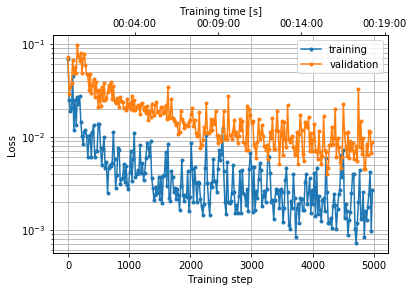

In [71]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [215]:
res = model.predict(x_val)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_global_reg_cos_10neighbours_K5/model-4992


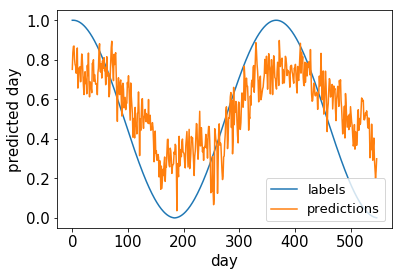

In [216]:
plt.plot(labels_val, label='labels')
plt.plot(res, label='predictions')
plt.xlabel('day', fontsize=15)
plt.ylabel('predicted day', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=13)
# plt.ylim(top=1.1)
plt.savefig(pathfig+'global_linear_results.png', bboxes_inches='tight')

In [161]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
def mre(labels, predictions):
    return np.mean(np.abs((labels - predictions) / np.clip(labels, 1, None))) * 100

In [197]:
res = model.predict(np.atleast_3d(x_val))

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K10_less_random/model-9953


In [198]:
mse_ = (mean_squared_error(labels_val[:-1,:], res[1:,:]))
mae_ = (mean_absolute_error(labels_val[:-1,:], res[1:,:]))
mre_ = (mre(labels_val[:-1,:], res[1:,:]))
r2_ = (r2_score(labels_val[:-1,:], res[1:,:]))
expvar_ = (explained_variance_score(labels_val[:-1,:], res[1:,:]))
print("MSE={:.2f}, MAE={:.2f}, MRE={:.2f}, R2={:.3f}, Expvar={:.4f}".format(mse_, mae_, mre_, r2_, expvar_))

MSE=141.68, MAE=10.82, MRE=291.34, R2=-0.389, Expvar=-0.3868


In [168]:
predictions = []
for i in range(days_pred):
    predictions.append(dataset_temp_reg[i,:,0])
for i in tqdm(range(len(dataset_temp_reg)-2*days_pred)):
    x_pred = np.asarray(predictions[-days_pred:]).T
    x_pred = np.hstack([x_pred, 
#                      np.broadcast_to(w_months[np.newaxis,i:i+days_pred], x_pred.shape),
                       coords_v,
                       alt_v[:,np.newaxis],
                       np.repeat(w_days_sin[i], x_pred.shape[0], axis=0)[:,np.newaxis]])
                       #np.broadcast_to(w_days[np.newaxis, i:i+days_pred], x_pred.shape)])
    x_pred = np.repeat(x_pred[np.newaxis,:,:], 64, axis=0)
    res = model.predict(x_pred)
    predictions.append(res[0,:])

  0%|          | 0/1816 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 1/1816 [00:00<14:02,  2.15it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 2/1816 [00:00<13:52,  2.18it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 3/1816 [00:01<13:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 4/1816 [00:01<13:27,  2.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 5/1816 [00:02<13:15,  2.28it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 6/1816 [00:02<13:24,  2.25it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 7/1816 [00:03<13:32,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 8/1816 [00:03<13:42,  2.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  0%|          | 9/1816 [00:04<13:42,  2.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 10/1816 [00:04<13:45,  2.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 11/1816 [00:05<13:45,  2.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 12/1816 [00:05<13:43,  2.19it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 13/1816 [00:05<13:39,  2.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 14/1816 [00:06<13:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 15/1816 [00:06<13:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 16/1816 [00:07<13:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 17/1816 [00:07<13:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 18/1816 [00:08<13:26,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 19/1816 [00:08<13:21,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 20/1816 [00:08<13:21,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 21/1816 [00:09<13:21,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|          | 22/1816 [00:09<13:22,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|▏         | 23/1816 [00:10<13:22,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|▏         | 24/1816 [00:10<13:22,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|▏         | 25/1816 [00:11<13:22,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|▏         | 26/1816 [00:11<13:21,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  1%|▏         | 27/1816 [00:12<13:20,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 28/1816 [00:12<13:17,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 29/1816 [00:12<13:17,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 30/1816 [00:13<13:19,  2.24it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 31/1816 [00:13<13:19,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 32/1816 [00:14<13:21,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 33/1816 [00:14<13:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 34/1816 [00:15<13:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 35/1816 [00:15<13:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 36/1816 [00:16<13:19,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 37/1816 [00:16<13:17,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 38/1816 [00:17<13:16,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 39/1816 [00:17<13:15,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 40/1816 [00:17<13:15,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 41/1816 [00:18<13:15,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 42/1816 [00:18<13:15,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 43/1816 [00:19<13:14,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 44/1816 [00:19<13:16,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  2%|▏         | 45/1816 [00:20<13:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 46/1816 [00:20<13:15,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 47/1816 [00:21<13:14,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 48/1816 [00:21<13:13,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 49/1816 [00:21<13:13,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 50/1816 [00:22<13:12,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 51/1816 [00:22<13:12,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 52/1816 [00:23<13:12,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 53/1816 [00:23<13:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 54/1816 [00:24<13:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 55/1816 [00:24<13:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 56/1816 [00:25<13:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 57/1816 [00:25<13:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 58/1816 [00:26<13:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 59/1816 [00:26<13:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 60/1816 [00:27<13:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 61/1816 [00:27<13:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 62/1816 [00:27<13:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  3%|▎         | 63/1816 [00:28<13:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▎         | 64/1816 [00:28<13:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▎         | 65/1816 [00:29<13:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▎         | 66/1816 [00:29<13:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▎         | 67/1816 [00:30<13:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▎         | 68/1816 [00:30<13:12,  2.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 69/1816 [00:31<13:12,  2.20it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 70/1816 [00:31<13:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 71/1816 [00:32<13:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 72/1816 [00:32<13:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 73/1816 [00:33<13:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 74/1816 [00:33<13:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 75/1816 [00:34<13:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 76/1816 [00:34<13:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 77/1816 [00:34<13:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 78/1816 [00:35<13:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 79/1816 [00:35<13:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 80/1816 [00:36<13:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  4%|▍         | 81/1816 [00:36<13:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 82/1816 [00:37<13:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 83/1816 [00:37<13:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 84/1816 [00:37<13:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 85/1816 [00:38<13:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 86/1816 [00:38<13:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 87/1816 [00:39<12:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 88/1816 [00:39<12:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 89/1816 [00:40<12:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▍         | 90/1816 [00:40<12:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 91/1816 [00:41<12:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 92/1816 [00:41<12:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 93/1816 [00:41<12:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 94/1816 [00:42<12:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 95/1816 [00:42<12:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 96/1816 [00:43<12:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 97/1816 [00:43<12:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 98/1816 [00:44<12:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  5%|▌         | 99/1816 [00:44<12:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 100/1816 [00:45<12:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 101/1816 [00:45<12:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 102/1816 [00:45<12:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 103/1816 [00:46<12:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 104/1816 [00:46<12:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 105/1816 [00:47<12:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 106/1816 [00:47<12:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 107/1816 [00:48<12:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 108/1816 [00:48<12:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 109/1816 [00:49<12:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 110/1816 [00:49<12:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 111/1816 [00:50<12:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 112/1816 [00:50<12:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▌         | 113/1816 [00:50<12:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▋         | 114/1816 [00:51<12:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▋         | 115/1816 [00:51<12:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▋         | 116/1816 [00:52<12:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▋         | 117/1816 [00:52<12:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  6%|▋         | 118/1816 [00:53<12:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 119/1816 [00:53<12:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 120/1816 [00:54<12:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 121/1816 [00:54<12:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 122/1816 [00:55<12:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 123/1816 [00:55<12:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 124/1816 [00:55<12:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 125/1816 [00:56<12:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 126/1816 [00:56<12:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 127/1816 [00:57<12:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 128/1816 [00:57<12:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 129/1816 [00:58<12:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 130/1816 [00:58<12:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 131/1816 [00:59<12:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 132/1816 [00:59<12:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 133/1816 [00:59<12:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 134/1816 [01:00<12:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 135/1816 [01:00<12:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  7%|▋         | 136/1816 [01:01<12:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 137/1816 [01:01<12:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 138/1816 [01:02<12:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 139/1816 [01:02<12:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 140/1816 [01:03<12:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 141/1816 [01:03<12:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 142/1816 [01:03<12:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 143/1816 [01:04<12:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 144/1816 [01:04<12:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 145/1816 [01:05<12:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 146/1816 [01:05<12:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 147/1816 [01:06<12:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 148/1816 [01:06<12:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 149/1816 [01:07<12:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 150/1816 [01:07<12:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 151/1816 [01:07<12:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 152/1816 [01:08<12:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 153/1816 [01:08<12:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  8%|▊         | 154/1816 [01:09<12:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▊         | 155/1816 [01:09<12:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▊         | 156/1816 [01:10<12:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▊         | 157/1816 [01:10<12:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▊         | 158/1816 [01:11<12:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 159/1816 [01:11<12:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 160/1816 [01:12<12:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 161/1816 [01:12<12:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 162/1816 [01:12<12:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 163/1816 [01:13<12:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 164/1816 [01:13<12:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 165/1816 [01:14<12:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 166/1816 [01:14<12:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 167/1816 [01:15<12:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 168/1816 [01:15<12:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 169/1816 [01:16<12:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 170/1816 [01:16<12:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 171/1816 [01:16<12:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


  9%|▉         | 172/1816 [01:17<12:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 173/1816 [01:17<12:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 174/1816 [01:18<12:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 175/1816 [01:18<12:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 176/1816 [01:19<12:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 177/1816 [01:19<12:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 178/1816 [01:20<12:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 179/1816 [01:20<12:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 180/1816 [01:20<12:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|▉         | 181/1816 [01:21<12:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 182/1816 [01:21<12:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 183/1816 [01:22<12:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 184/1816 [01:22<12:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 185/1816 [01:23<12:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 186/1816 [01:23<12:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 187/1816 [01:24<12:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 188/1816 [01:24<12:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 189/1816 [01:25<12:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 10%|█         | 190/1816 [01:25<12:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 191/1816 [01:25<12:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 192/1816 [01:26<12:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 193/1816 [01:26<12:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 194/1816 [01:27<12:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 195/1816 [01:27<12:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 196/1816 [01:28<12:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 197/1816 [01:28<12:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 198/1816 [01:29<12:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 199/1816 [01:29<12:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 200/1816 [01:30<12:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 201/1816 [01:30<12:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 202/1816 [01:30<12:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 203/1816 [01:31<12:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█         | 204/1816 [01:31<12:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█▏        | 205/1816 [01:32<12:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█▏        | 206/1816 [01:32<12:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█▏        | 207/1816 [01:33<12:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 11%|█▏        | 208/1816 [01:33<12:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 209/1816 [01:34<12:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 210/1816 [01:34<12:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 211/1816 [01:34<12:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 212/1816 [01:35<12:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 213/1816 [01:35<12:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 214/1816 [01:36<12:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 215/1816 [01:36<12:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 216/1816 [01:37<11:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 217/1816 [01:37<11:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 218/1816 [01:38<11:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 219/1816 [01:38<11:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 220/1816 [01:38<11:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 221/1816 [01:39<11:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 222/1816 [01:39<11:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 223/1816 [01:40<11:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 224/1816 [01:40<11:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 225/1816 [01:41<11:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▏        | 226/1816 [01:41<11:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 12%|█▎        | 227/1816 [01:42<11:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 228/1816 [01:42<11:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 229/1816 [01:42<11:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 230/1816 [01:43<11:52,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 231/1816 [01:43<11:52,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 232/1816 [01:44<11:51,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 233/1816 [01:44<11:51,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 234/1816 [01:45<11:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 235/1816 [01:45<11:50,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 236/1816 [01:46<11:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 237/1816 [01:46<11:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 238/1816 [01:46<11:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 239/1816 [01:47<11:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 240/1816 [01:47<11:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 241/1816 [01:48<11:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 242/1816 [01:48<11:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 243/1816 [01:49<11:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 244/1816 [01:49<11:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 13%|█▎        | 245/1816 [01:50<11:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▎        | 246/1816 [01:50<11:45,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▎        | 247/1816 [01:51<11:45,  2.23it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▎        | 248/1816 [01:51<11:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▎        | 249/1816 [01:51<11:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 250/1816 [01:52<11:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 251/1816 [01:52<11:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 252/1816 [01:53<11:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 253/1816 [01:53<11:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 254/1816 [01:54<11:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 255/1816 [01:54<11:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 256/1816 [01:55<11:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 257/1816 [01:55<11:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 258/1816 [01:56<11:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 259/1816 [01:56<11:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 260/1816 [01:57<11:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 261/1816 [01:57<11:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 262/1816 [01:57<11:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 14%|█▍        | 263/1816 [01:58<11:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 264/1816 [01:58<11:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 265/1816 [01:59<11:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 266/1816 [01:59<11:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 267/1816 [02:00<11:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 268/1816 [02:00<11:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 269/1816 [02:01<11:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 270/1816 [02:01<11:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 271/1816 [02:02<11:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▍        | 272/1816 [02:02<11:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 273/1816 [02:02<11:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 274/1816 [02:03<11:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 275/1816 [02:03<11:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 276/1816 [02:04<11:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 277/1816 [02:04<11:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 278/1816 [02:05<11:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 279/1816 [02:05<11:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 280/1816 [02:06<11:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 15%|█▌        | 281/1816 [02:06<11:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 282/1816 [02:06<11:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 283/1816 [02:07<11:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 284/1816 [02:07<11:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 285/1816 [02:08<11:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 286/1816 [02:08<11:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 287/1816 [02:09<11:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 288/1816 [02:09<11:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 289/1816 [02:10<11:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 290/1816 [02:10<11:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 291/1816 [02:10<11:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 292/1816 [02:11<11:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 293/1816 [02:11<11:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 294/1816 [02:12<11:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▌        | 295/1816 [02:12<11:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▋        | 296/1816 [02:13<11:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▋        | 297/1816 [02:13<11:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▋        | 298/1816 [02:14<11:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 16%|█▋        | 299/1816 [02:14<11:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 300/1816 [02:15<11:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 301/1816 [02:15<11:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 302/1816 [02:16<11:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 303/1816 [02:16<11:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 304/1816 [02:16<11:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 305/1816 [02:17<11:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 306/1816 [02:17<11:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 307/1816 [02:18<11:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 308/1816 [02:18<11:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 309/1816 [02:20<11:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 310/1816 [02:20<11:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 311/1816 [02:20<11:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 312/1816 [02:21<11:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 313/1816 [02:21<11:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 314/1816 [02:22<11:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 315/1816 [02:22<11:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 316/1816 [02:23<11:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 17%|█▋        | 317/1816 [02:23<11:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 318/1816 [02:24<11:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 319/1816 [02:24<11:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 320/1816 [02:24<11:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 321/1816 [02:25<11:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 322/1816 [02:25<11:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 323/1816 [02:26<11:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 324/1816 [02:26<11:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 325/1816 [02:27<11:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 326/1816 [02:27<11:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 327/1816 [02:28<11:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 328/1816 [02:28<11:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 329/1816 [02:28<11:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 330/1816 [02:29<11:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 331/1816 [02:29<11:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 332/1816 [02:30<11:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 333/1816 [02:30<11:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 334/1816 [02:31<11:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 18%|█▊        | 335/1816 [02:31<11:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▊        | 336/1816 [02:32<11:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▊        | 337/1816 [02:32<11:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▊        | 338/1816 [02:33<11:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▊        | 339/1816 [02:33<11:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▊        | 340/1816 [02:33<11:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 341/1816 [02:34<11:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 342/1816 [02:34<11:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 343/1816 [02:35<11:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 344/1816 [02:35<11:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 345/1816 [02:36<11:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 346/1816 [02:36<11:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 347/1816 [02:37<11:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 348/1816 [02:37<11:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 349/1816 [02:38<11:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 350/1816 [02:38<11:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 351/1816 [02:39<11:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 352/1816 [02:39<11:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 353/1816 [02:39<11:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 19%|█▉        | 354/1816 [02:40<11:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 355/1816 [02:40<11:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 356/1816 [02:41<11:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 357/1816 [02:41<11:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 358/1816 [02:42<11:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 359/1816 [02:42<11:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 360/1816 [02:43<10:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 361/1816 [02:43<10:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 362/1816 [02:43<10:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|█▉        | 363/1816 [02:44<10:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 364/1816 [02:44<10:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 365/1816 [02:45<10:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 366/1816 [02:45<10:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 367/1816 [02:46<10:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 368/1816 [02:46<10:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 369/1816 [02:47<10:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 370/1816 [02:47<10:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 371/1816 [02:47<10:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 20%|██        | 372/1816 [02:48<10:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 373/1816 [02:48<10:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 374/1816 [02:49<10:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 375/1816 [02:49<10:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 376/1816 [02:50<10:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 377/1816 [02:50<10:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 378/1816 [02:51<10:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 379/1816 [02:51<10:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 380/1816 [02:52<10:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 381/1816 [02:52<10:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 382/1816 [02:53<10:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 383/1816 [02:53<10:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 384/1816 [02:53<10:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██        | 385/1816 [02:54<10:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██▏       | 386/1816 [02:54<10:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██▏       | 387/1816 [02:55<10:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██▏       | 388/1816 [02:55<10:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██▏       | 389/1816 [02:56<10:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 21%|██▏       | 390/1816 [02:56<10:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 391/1816 [02:57<10:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 392/1816 [02:57<10:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 393/1816 [02:57<10:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 394/1816 [02:58<10:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 395/1816 [02:58<10:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 396/1816 [02:59<10:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 397/1816 [02:59<10:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 398/1816 [03:00<10:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 399/1816 [03:00<10:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 400/1816 [03:00<10:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 401/1816 [03:01<10:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 402/1816 [03:01<10:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 403/1816 [03:02<10:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 404/1816 [03:02<10:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 405/1816 [03:03<10:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 406/1816 [03:03<10:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 407/1816 [03:04<10:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 22%|██▏       | 408/1816 [03:04<10:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 409/1816 [03:04<10:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 410/1816 [03:05<10:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 411/1816 [03:05<10:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 412/1816 [03:06<10:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 413/1816 [03:06<10:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 414/1816 [03:07<10:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 415/1816 [03:07<10:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 416/1816 [03:08<10:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 417/1816 [03:08<10:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 418/1816 [03:09<10:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 419/1816 [03:09<10:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 420/1816 [03:09<10:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 421/1816 [03:10<10:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 422/1816 [03:10<10:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 423/1816 [03:11<10:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 424/1816 [03:11<10:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 425/1816 [03:12<10:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 23%|██▎       | 426/1816 [03:12<10:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▎       | 427/1816 [03:13<10:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▎       | 428/1816 [03:13<10:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▎       | 429/1816 [03:13<10:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▎       | 430/1816 [03:14<10:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▎       | 431/1816 [03:14<10:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 432/1816 [03:15<10:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 433/1816 [03:15<10:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 434/1816 [03:16<10:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 435/1816 [03:16<10:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 436/1816 [03:17<10:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 437/1816 [03:17<10:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 438/1816 [03:17<10:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 439/1816 [03:18<10:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 440/1816 [03:18<10:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 441/1816 [03:19<10:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 442/1816 [03:19<10:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 443/1816 [03:20<10:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 24%|██▍       | 444/1816 [03:20<10:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 445/1816 [03:21<10:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 446/1816 [03:21<10:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 447/1816 [03:22<10:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 448/1816 [03:22<10:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 449/1816 [03:22<10:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 450/1816 [03:23<10:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 451/1816 [03:23<10:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 452/1816 [03:24<10:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▍       | 453/1816 [03:24<10:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 454/1816 [03:25<10:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 455/1816 [03:25<10:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 456/1816 [03:26<10:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 457/1816 [03:26<10:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 458/1816 [03:26<10:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 459/1816 [03:27<10:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 460/1816 [03:27<10:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 461/1816 [03:28<10:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 462/1816 [03:28<10:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 25%|██▌       | 463/1816 [03:29<10:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 464/1816 [03:29<10:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 465/1816 [03:30<10:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 466/1816 [03:30<10:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 467/1816 [03:30<10:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 468/1816 [03:31<10:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 469/1816 [03:31<10:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 470/1816 [03:32<10:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 471/1816 [03:32<10:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 472/1816 [03:33<10:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 473/1816 [03:33<10:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 474/1816 [03:34<10:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 475/1816 [03:34<10:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▌       | 476/1816 [03:35<10:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▋       | 477/1816 [03:35<10:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▋       | 478/1816 [03:35<10:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▋       | 479/1816 [03:36<10:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▋       | 480/1816 [03:36<10:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 26%|██▋       | 481/1816 [03:37<10:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 482/1816 [03:37<10:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 483/1816 [03:38<10:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 484/1816 [03:38<10:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 485/1816 [03:39<10:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 486/1816 [03:39<10:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 487/1816 [03:39<10:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 488/1816 [03:40<09:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 489/1816 [03:40<09:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 490/1816 [03:41<09:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 491/1816 [03:41<09:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 492/1816 [03:42<09:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 493/1816 [03:42<09:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 494/1816 [03:43<09:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 495/1816 [03:43<09:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 496/1816 [03:43<09:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 497/1816 [03:44<09:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 498/1816 [03:44<09:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 27%|██▋       | 499/1816 [03:45<09:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 500/1816 [03:45<09:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 501/1816 [03:46<09:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 502/1816 [03:46<09:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 503/1816 [03:47<09:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 504/1816 [03:47<09:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 505/1816 [03:47<09:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 506/1816 [03:48<09:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 507/1816 [03:48<09:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 508/1816 [03:49<09:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 509/1816 [03:49<09:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 510/1816 [03:50<09:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 511/1816 [03:50<09:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 512/1816 [03:51<09:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 513/1816 [03:51<09:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 514/1816 [03:51<09:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 515/1816 [03:52<09:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 516/1816 [03:52<09:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 28%|██▊       | 517/1816 [03:53<09:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▊       | 518/1816 [03:53<09:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▊       | 519/1816 [03:54<09:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▊       | 520/1816 [03:54<09:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▊       | 521/1816 [03:55<09:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▊       | 522/1816 [03:55<09:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 523/1816 [03:55<09:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 524/1816 [03:56<09:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 525/1816 [03:56<09:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 526/1816 [03:57<09:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 527/1816 [03:57<09:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 528/1816 [03:58<09:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 529/1816 [03:58<09:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 530/1816 [03:59<09:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 531/1816 [03:59<09:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 532/1816 [04:00<09:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 533/1816 [04:00<09:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 534/1816 [04:00<09:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 29%|██▉       | 535/1816 [04:01<09:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 536/1816 [04:01<09:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 537/1816 [04:02<09:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 538/1816 [04:02<09:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 539/1816 [04:03<09:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 540/1816 [04:03<09:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 541/1816 [04:04<09:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 542/1816 [04:04<09:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 543/1816 [04:04<09:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|██▉       | 544/1816 [04:05<09:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 545/1816 [04:05<09:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 546/1816 [04:06<09:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 547/1816 [04:06<09:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 548/1816 [04:07<09:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 549/1816 [04:07<09:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 550/1816 [04:08<09:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 551/1816 [04:08<09:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 552/1816 [04:08<09:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 30%|███       | 553/1816 [04:09<09:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 554/1816 [04:09<09:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 555/1816 [04:10<09:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 556/1816 [04:10<09:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 557/1816 [04:11<09:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 558/1816 [04:11<09:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 559/1816 [04:12<09:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 560/1816 [04:12<09:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 561/1816 [04:13<09:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 562/1816 [04:13<09:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 563/1816 [04:14<09:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 564/1816 [04:14<09:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 565/1816 [04:14<09:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 566/1816 [04:15<09:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███       | 567/1816 [04:15<09:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███▏      | 568/1816 [04:16<09:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███▏      | 569/1816 [04:16<09:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███▏      | 570/1816 [04:17<09:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███▏      | 571/1816 [04:17<09:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 31%|███▏      | 572/1816 [04:18<09:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 573/1816 [04:18<09:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 574/1816 [04:18<09:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 575/1816 [04:19<09:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 576/1816 [04:19<09:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 577/1816 [04:20<09:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 578/1816 [04:20<09:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 579/1816 [04:21<09:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 580/1816 [04:21<09:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 581/1816 [04:21<09:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 582/1816 [04:22<09:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 583/1816 [04:22<09:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 584/1816 [04:23<09:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 585/1816 [04:23<09:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 586/1816 [04:24<09:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 587/1816 [04:24<09:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 588/1816 [04:25<09:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 589/1816 [04:25<09:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 32%|███▏      | 590/1816 [04:26<09:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 591/1816 [04:26<09:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 592/1816 [04:26<09:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 593/1816 [04:27<09:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 594/1816 [04:27<09:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 595/1816 [04:28<09:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 596/1816 [04:28<09:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 597/1816 [04:29<09:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 598/1816 [04:29<09:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 599/1816 [04:30<09:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 600/1816 [04:30<09:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 601/1816 [04:31<09:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 602/1816 [04:31<09:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 603/1816 [04:31<09:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 604/1816 [04:32<09:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 605/1816 [04:32<09:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 606/1816 [04:33<09:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 607/1816 [04:33<09:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 33%|███▎      | 608/1816 [04:34<09:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▎      | 609/1816 [04:34<09:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▎      | 610/1816 [04:35<09:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▎      | 611/1816 [04:35<09:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▎      | 612/1816 [04:35<09:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 613/1816 [04:36<09:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 614/1816 [04:36<09:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 615/1816 [04:37<09:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 616/1816 [04:37<09:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 617/1816 [04:38<09:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 618/1816 [04:38<09:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 619/1816 [04:39<08:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 620/1816 [04:39<08:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 621/1816 [04:39<08:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 622/1816 [04:40<08:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 623/1816 [04:40<08:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 624/1816 [04:41<08:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 625/1816 [04:41<08:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 34%|███▍      | 626/1816 [04:42<08:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 627/1816 [04:42<08:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 628/1816 [04:43<08:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 629/1816 [04:43<08:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 630/1816 [04:43<08:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 631/1816 [04:44<08:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 632/1816 [04:44<08:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 633/1816 [04:45<08:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 634/1816 [04:45<08:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▍      | 635/1816 [04:46<08:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 636/1816 [04:46<08:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 637/1816 [04:47<08:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 638/1816 [04:47<08:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 639/1816 [04:47<08:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 640/1816 [04:48<08:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 641/1816 [04:48<08:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 642/1816 [04:49<08:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 643/1816 [04:49<08:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 35%|███▌      | 644/1816 [04:50<08:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 645/1816 [04:50<08:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 646/1816 [04:51<08:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 647/1816 [04:51<08:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 648/1816 [04:52<08:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 649/1816 [04:52<08:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 650/1816 [04:52<08:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 651/1816 [04:53<08:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 652/1816 [04:53<08:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 653/1816 [04:54<08:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 654/1816 [04:54<08:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 655/1816 [04:55<08:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 656/1816 [04:55<08:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 657/1816 [04:56<08:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▌      | 658/1816 [04:56<08:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▋      | 659/1816 [04:56<08:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▋      | 660/1816 [04:57<08:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▋      | 661/1816 [04:57<08:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 36%|███▋      | 662/1816 [04:58<08:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 663/1816 [04:58<08:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 664/1816 [04:59<08:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 665/1816 [04:59<08:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 666/1816 [05:00<08:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 667/1816 [05:00<08:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 668/1816 [05:00<08:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 669/1816 [05:01<08:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 670/1816 [05:01<08:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 671/1816 [05:02<08:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 672/1816 [05:02<08:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 673/1816 [05:03<08:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 674/1816 [05:03<08:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 675/1816 [05:04<08:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 676/1816 [05:04<08:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 677/1816 [05:05<08:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 678/1816 [05:05<08:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 679/1816 [05:05<08:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 37%|███▋      | 680/1816 [05:06<08:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 681/1816 [05:06<08:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 682/1816 [05:07<08:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 683/1816 [05:07<08:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 684/1816 [05:08<08:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 685/1816 [05:08<08:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 686/1816 [05:09<08:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 687/1816 [05:09<08:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 688/1816 [05:10<08:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 689/1816 [05:10<08:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 690/1816 [05:11<08:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 691/1816 [05:11<08:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 692/1816 [05:11<08:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 693/1816 [05:12<08:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 694/1816 [05:12<08:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 695/1816 [05:13<08:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 696/1816 [05:13<08:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 697/1816 [05:14<08:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 698/1816 [05:14<08:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 38%|███▊      | 699/1816 [05:15<08:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▊      | 700/1816 [05:15<08:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▊      | 701/1816 [05:15<08:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▊      | 702/1816 [05:16<08:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▊      | 703/1816 [05:16<08:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 704/1816 [05:17<08:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 705/1816 [05:17<08:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 706/1816 [05:18<08:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 707/1816 [05:18<08:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 708/1816 [05:19<08:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 709/1816 [05:19<08:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 710/1816 [05:19<08:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 711/1816 [05:20<08:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 712/1816 [05:20<08:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 713/1816 [05:21<08:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 714/1816 [05:21<08:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 715/1816 [05:22<08:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 716/1816 [05:22<08:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 39%|███▉      | 717/1816 [05:23<08:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 718/1816 [05:23<08:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 719/1816 [05:23<08:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 720/1816 [05:24<08:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 721/1816 [05:24<08:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 722/1816 [05:25<08:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 723/1816 [05:25<08:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 724/1816 [05:26<08:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 725/1816 [05:26<08:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|███▉      | 726/1816 [05:27<08:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 727/1816 [05:27<08:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 728/1816 [05:28<08:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 729/1816 [05:28<08:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 730/1816 [05:28<08:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 731/1816 [05:29<08:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 732/1816 [05:29<08:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 733/1816 [05:30<08:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 734/1816 [05:30<08:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 40%|████      | 735/1816 [05:31<08:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 736/1816 [05:31<08:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 737/1816 [05:31<08:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 738/1816 [05:32<08:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 739/1816 [05:32<08:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 740/1816 [05:33<08:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 741/1816 [05:33<08:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 742/1816 [05:34<08:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 743/1816 [05:34<08:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 744/1816 [05:35<08:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 745/1816 [05:35<08:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 746/1816 [05:36<08:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 747/1816 [05:36<08:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 748/1816 [05:36<08:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████      | 749/1816 [05:37<08:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████▏     | 750/1816 [05:37<08:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████▏     | 751/1816 [05:38<07:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████▏     | 752/1816 [05:38<07:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 41%|████▏     | 753/1816 [05:39<07:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 754/1816 [05:39<07:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 755/1816 [05:40<07:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 756/1816 [05:40<07:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 757/1816 [05:40<07:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 758/1816 [05:41<07:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 759/1816 [05:41<07:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 760/1816 [05:42<07:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 761/1816 [05:42<07:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 762/1816 [05:43<07:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 763/1816 [05:43<07:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 764/1816 [05:44<07:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 765/1816 [05:44<07:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 766/1816 [05:45<07:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 767/1816 [05:45<07:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 768/1816 [05:45<07:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 769/1816 [05:46<07:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 770/1816 [05:46<07:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 42%|████▏     | 771/1816 [05:47<07:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 772/1816 [05:47<07:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 773/1816 [05:48<07:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 774/1816 [05:48<07:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 775/1816 [05:49<07:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 776/1816 [05:49<07:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 777/1816 [05:50<07:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 778/1816 [05:50<07:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 779/1816 [05:51<07:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 780/1816 [05:51<07:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 781/1816 [05:51<07:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 782/1816 [05:52<07:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 783/1816 [05:52<07:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 784/1816 [05:53<07:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 785/1816 [05:53<07:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 786/1816 [05:54<07:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 787/1816 [05:54<07:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 788/1816 [05:55<07:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 43%|████▎     | 789/1816 [05:55<07:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▎     | 790/1816 [05:56<07:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▎     | 791/1816 [05:56<07:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▎     | 792/1816 [05:56<07:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▎     | 793/1816 [05:57<07:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▎     | 794/1816 [05:57<07:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 795/1816 [05:58<07:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 796/1816 [05:58<07:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 797/1816 [05:59<07:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 798/1816 [05:59<07:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 799/1816 [06:00<07:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 800/1816 [06:00<07:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 801/1816 [06:00<07:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 802/1816 [06:01<07:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 803/1816 [06:01<07:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 804/1816 [06:02<07:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 805/1816 [06:02<07:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 806/1816 [06:03<07:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 807/1816 [06:03<07:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 44%|████▍     | 808/1816 [06:04<07:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 809/1816 [06:04<07:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 810/1816 [06:05<07:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 811/1816 [06:05<07:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 812/1816 [06:05<07:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 813/1816 [06:06<07:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 814/1816 [06:06<07:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 815/1816 [06:07<07:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 816/1816 [06:07<07:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▍     | 817/1816 [06:08<07:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 818/1816 [06:08<07:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 819/1816 [06:08<07:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 820/1816 [06:09<07:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 821/1816 [06:09<07:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 822/1816 [06:10<07:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 823/1816 [06:10<07:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 824/1816 [06:11<07:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 825/1816 [06:11<07:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 45%|████▌     | 826/1816 [06:12<07:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 827/1816 [06:12<07:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 828/1816 [06:13<07:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 829/1816 [06:13<07:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 830/1816 [06:13<07:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 831/1816 [06:14<07:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 832/1816 [06:14<07:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 833/1816 [06:15<07:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 834/1816 [06:15<07:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 835/1816 [06:16<07:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 836/1816 [06:16<07:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 837/1816 [06:17<07:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 838/1816 [06:17<07:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▌     | 839/1816 [06:17<07:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▋     | 840/1816 [06:18<07:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▋     | 841/1816 [06:18<07:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▋     | 842/1816 [06:19<07:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▋     | 843/1816 [06:19<07:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 46%|████▋     | 844/1816 [06:20<07:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 845/1816 [06:20<07:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 846/1816 [06:21<07:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 847/1816 [06:21<07:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 848/1816 [06:21<07:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 849/1816 [06:22<07:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 850/1816 [06:22<07:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 851/1816 [06:23<07:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 852/1816 [06:23<07:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 853/1816 [06:24<07:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 854/1816 [06:24<07:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 855/1816 [06:25<07:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 856/1816 [06:25<07:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 857/1816 [06:25<07:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 858/1816 [06:26<07:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 859/1816 [06:26<07:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 860/1816 [06:27<07:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 861/1816 [06:27<07:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 47%|████▋     | 862/1816 [06:28<07:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 863/1816 [06:28<07:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 864/1816 [06:29<07:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 865/1816 [06:29<07:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 866/1816 [06:29<07:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 867/1816 [06:30<07:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 868/1816 [06:30<07:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 869/1816 [06:31<07:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 870/1816 [06:31<07:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 871/1816 [06:32<07:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 872/1816 [06:32<07:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 873/1816 [06:33<07:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 874/1816 [06:33<07:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 875/1816 [06:33<07:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 876/1816 [06:34<07:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 877/1816 [06:34<07:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 878/1816 [06:35<07:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 879/1816 [06:35<07:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 48%|████▊     | 880/1816 [06:36<07:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▊     | 881/1816 [06:36<07:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▊     | 882/1816 [06:36<07:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▊     | 883/1816 [06:37<06:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▊     | 884/1816 [06:37<06:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▊     | 885/1816 [06:38<06:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 886/1816 [06:38<06:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 887/1816 [06:39<06:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 888/1816 [06:39<06:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 889/1816 [06:40<06:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 890/1816 [06:40<06:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 891/1816 [06:41<06:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 892/1816 [06:41<06:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 893/1816 [06:41<06:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 894/1816 [06:42<06:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 895/1816 [06:42<06:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 896/1816 [06:43<06:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 897/1816 [06:43<06:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 49%|████▉     | 898/1816 [06:44<06:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 899/1816 [06:44<06:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 900/1816 [06:44<06:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 901/1816 [06:45<06:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 902/1816 [06:45<06:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 903/1816 [06:46<06:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 904/1816 [06:46<06:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 905/1816 [06:47<06:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 906/1816 [06:47<06:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|████▉     | 907/1816 [06:48<06:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 908/1816 [06:48<06:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 909/1816 [06:48<06:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 910/1816 [06:49<06:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 911/1816 [06:49<06:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 912/1816 [06:50<06:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 913/1816 [06:50<06:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 914/1816 [06:51<06:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 915/1816 [06:51<06:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 916/1816 [06:52<06:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 50%|█████     | 917/1816 [06:52<06:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 918/1816 [06:52<06:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 919/1816 [06:53<06:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 920/1816 [06:53<06:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 921/1816 [06:54<06:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 922/1816 [06:54<06:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 923/1816 [06:55<06:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 924/1816 [06:55<06:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 925/1816 [06:56<06:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 926/1816 [06:56<06:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 927/1816 [06:56<06:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 928/1816 [06:57<06:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 929/1816 [06:57<06:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████     | 930/1816 [06:58<06:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████▏    | 931/1816 [06:58<06:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████▏    | 932/1816 [06:59<06:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████▏    | 933/1816 [06:59<06:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████▏    | 934/1816 [07:00<06:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 51%|█████▏    | 935/1816 [07:00<06:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 936/1816 [07:00<06:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 937/1816 [07:01<06:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 938/1816 [07:01<06:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 939/1816 [07:02<06:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 940/1816 [07:02<06:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 941/1816 [07:03<06:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 942/1816 [07:03<06:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 943/1816 [07:04<06:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 944/1816 [07:04<06:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 945/1816 [07:06<06:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 946/1816 [07:06<06:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 947/1816 [07:07<06:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 948/1816 [07:07<06:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 949/1816 [07:08<06:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 950/1816 [07:08<06:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 951/1816 [07:08<06:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 952/1816 [07:09<06:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 52%|█████▏    | 953/1816 [07:09<06:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 954/1816 [07:10<06:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 955/1816 [07:10<06:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 956/1816 [07:11<06:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 957/1816 [07:11<06:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 958/1816 [07:12<06:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 959/1816 [07:12<06:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 960/1816 [07:13<06:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 961/1816 [07:13<06:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 962/1816 [07:14<06:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 963/1816 [07:14<06:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 964/1816 [07:15<06:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 965/1816 [07:15<06:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 966/1816 [07:15<06:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 967/1816 [07:16<06:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 968/1816 [07:16<06:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 969/1816 [07:17<06:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 970/1816 [07:17<06:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 53%|█████▎    | 971/1816 [07:18<06:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▎    | 972/1816 [07:18<06:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▎    | 973/1816 [07:19<06:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▎    | 974/1816 [07:19<06:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▎    | 975/1816 [07:19<06:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▎    | 976/1816 [07:20<06:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 977/1816 [07:20<06:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 978/1816 [07:21<06:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 979/1816 [07:21<06:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 980/1816 [07:22<06:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 981/1816 [07:22<06:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 982/1816 [07:23<06:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 983/1816 [07:23<06:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 984/1816 [07:24<06:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 985/1816 [07:24<06:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 986/1816 [07:24<06:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 987/1816 [07:25<06:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 988/1816 [07:25<06:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 54%|█████▍    | 989/1816 [07:26<06:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 990/1816 [07:26<06:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 991/1816 [07:27<06:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 992/1816 [07:27<06:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 993/1816 [07:28<06:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 994/1816 [07:28<06:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 995/1816 [07:29<06:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 996/1816 [07:29<06:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 997/1816 [07:29<06:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▍    | 998/1816 [07:30<06:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 999/1816 [07:30<06:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1000/1816 [07:31<06:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1001/1816 [07:31<06:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1002/1816 [07:32<06:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1003/1816 [07:32<06:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1004/1816 [07:32<06:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1005/1816 [07:33<06:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1006/1816 [07:33<06:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 55%|█████▌    | 1007/1816 [07:34<06:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1008/1816 [07:34<06:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1009/1816 [07:35<06:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1010/1816 [07:35<06:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1011/1816 [07:36<06:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1012/1816 [07:36<06:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1013/1816 [07:36<06:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1014/1816 [07:37<06:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1015/1816 [07:37<06:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1016/1816 [07:38<06:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1017/1816 [07:38<06:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1018/1816 [07:39<05:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1019/1816 [07:39<05:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1020/1816 [07:39<05:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▌    | 1021/1816 [07:40<05:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▋    | 1022/1816 [07:40<05:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▋    | 1023/1816 [07:41<05:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▋    | 1024/1816 [07:41<05:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▋    | 1025/1816 [07:42<05:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 56%|█████▋    | 1026/1816 [07:42<05:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1027/1816 [07:43<05:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1028/1816 [07:43<05:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1029/1816 [07:44<05:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1030/1816 [07:44<05:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1031/1816 [07:44<05:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1032/1816 [07:45<05:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1033/1816 [07:45<05:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1034/1816 [07:46<05:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1035/1816 [07:46<05:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1036/1816 [07:47<05:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1037/1816 [07:47<05:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1038/1816 [07:48<05:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1039/1816 [07:48<05:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1040/1816 [07:48<05:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1041/1816 [07:49<05:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1042/1816 [07:49<05:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1043/1816 [07:50<05:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 57%|█████▋    | 1044/1816 [07:50<05:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1045/1816 [07:51<05:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1046/1816 [07:51<05:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1047/1816 [07:52<05:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1048/1816 [07:52<05:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1049/1816 [07:53<05:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1050/1816 [07:53<05:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1051/1816 [07:53<05:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1052/1816 [07:54<05:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1053/1816 [07:54<05:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1054/1816 [07:55<05:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1055/1816 [07:55<05:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1056/1816 [07:56<05:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1057/1816 [07:56<05:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1058/1816 [07:57<05:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1059/1816 [07:57<05:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1060/1816 [07:58<05:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1061/1816 [07:58<05:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 58%|█████▊    | 1062/1816 [07:59<05:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▊    | 1063/1816 [07:59<05:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▊    | 1064/1816 [07:59<05:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▊    | 1065/1816 [08:00<05:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▊    | 1066/1816 [08:00<05:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1067/1816 [08:01<05:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1068/1816 [08:01<05:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1069/1816 [08:02<05:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1070/1816 [08:02<05:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1071/1816 [08:03<05:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1072/1816 [08:03<05:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1073/1816 [08:04<05:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1074/1816 [08:04<05:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1075/1816 [08:04<05:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1076/1816 [08:05<05:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1077/1816 [08:05<05:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1078/1816 [08:06<05:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1079/1816 [08:06<05:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 59%|█████▉    | 1080/1816 [08:07<05:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1081/1816 [08:07<05:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1082/1816 [08:08<05:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1083/1816 [08:08<05:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1084/1816 [08:08<05:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1085/1816 [08:09<05:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1086/1816 [08:09<05:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1087/1816 [08:10<05:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1088/1816 [08:10<05:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|█████▉    | 1089/1816 [08:11<05:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1090/1816 [08:11<05:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1091/1816 [08:12<05:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1092/1816 [08:12<05:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1093/1816 [08:13<05:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1094/1816 [08:13<05:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1095/1816 [08:14<05:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1096/1816 [08:14<05:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1097/1816 [08:15<05:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 60%|██████    | 1098/1816 [08:15<05:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1099/1816 [08:15<05:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1100/1816 [08:16<05:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1101/1816 [08:16<05:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1102/1816 [08:17<05:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1103/1816 [08:17<05:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1104/1816 [08:18<05:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1105/1816 [08:18<05:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1106/1816 [08:19<05:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1107/1816 [08:19<05:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1108/1816 [08:20<05:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1109/1816 [08:20<05:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1110/1816 [08:20<05:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1111/1816 [08:21<05:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████    | 1112/1816 [08:21<05:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████▏   | 1113/1816 [08:22<05:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████▏   | 1114/1816 [08:22<05:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████▏   | 1115/1816 [08:23<05:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 61%|██████▏   | 1116/1816 [08:23<05:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1117/1816 [08:24<05:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1118/1816 [08:24<05:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1119/1816 [08:24<05:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1120/1816 [08:25<05:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1121/1816 [08:25<05:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1122/1816 [08:26<05:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1123/1816 [08:26<05:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1124/1816 [08:27<05:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1125/1816 [08:27<05:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1126/1816 [08:28<05:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1127/1816 [08:28<05:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1128/1816 [08:28<05:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1129/1816 [08:29<05:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1130/1816 [08:29<05:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1131/1816 [08:30<05:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1132/1816 [08:30<05:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1133/1816 [08:31<05:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▏   | 1134/1816 [08:31<05:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 62%|██████▎   | 1135/1816 [08:32<05:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1136/1816 [08:32<05:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1137/1816 [08:33<05:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1138/1816 [08:33<05:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1139/1816 [08:33<05:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1140/1816 [08:34<05:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1141/1816 [08:34<05:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1142/1816 [08:35<05:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1143/1816 [08:35<05:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1144/1816 [08:36<05:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1145/1816 [08:36<05:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1146/1816 [08:37<05:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1147/1816 [08:37<05:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1148/1816 [08:38<05:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1149/1816 [08:38<05:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1150/1816 [08:38<05:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1151/1816 [08:39<05:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1152/1816 [08:39<04:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 63%|██████▎   | 1153/1816 [08:40<04:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▎   | 1154/1816 [08:40<04:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▎   | 1155/1816 [08:41<04:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▎   | 1156/1816 [08:41<04:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▎   | 1157/1816 [08:42<04:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1158/1816 [08:42<04:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1159/1816 [08:42<04:56,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1160/1816 [08:43<04:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1161/1816 [08:43<04:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1162/1816 [08:44<04:55,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1163/1816 [08:44<04:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1164/1816 [08:45<04:54,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1165/1816 [08:45<04:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1166/1816 [08:46<04:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1167/1816 [08:46<04:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1168/1816 [08:47<04:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1169/1816 [08:47<04:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1170/1816 [08:47<04:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 64%|██████▍   | 1171/1816 [08:48<04:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1172/1816 [08:48<04:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1173/1816 [08:49<04:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1174/1816 [08:49<04:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1175/1816 [08:50<04:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1176/1816 [08:50<04:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1177/1816 [08:51<04:48,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1178/1816 [08:51<04:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1179/1816 [08:51<04:47,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▍   | 1180/1816 [08:52<04:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1181/1816 [08:52<04:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1182/1816 [08:53<04:46,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1183/1816 [08:53<04:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1184/1816 [08:54<04:45,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1185/1816 [08:54<04:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1186/1816 [08:55<04:44,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1187/1816 [08:55<04:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1188/1816 [08:56<04:43,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 65%|██████▌   | 1189/1816 [08:56<04:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1190/1816 [08:56<04:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1191/1816 [08:57<04:42,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1192/1816 [08:57<04:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1193/1816 [08:58<04:41,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1194/1816 [08:58<04:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1195/1816 [08:59<04:40,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1196/1816 [08:59<04:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1197/1816 [09:00<04:39,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1198/1816 [09:00<04:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1199/1816 [09:01<04:38,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1200/1816 [09:01<04:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1201/1816 [09:01<04:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1202/1816 [09:02<04:37,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▌   | 1203/1816 [09:02<04:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▋   | 1204/1816 [09:03<04:36,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▋   | 1205/1816 [09:03<04:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▋   | 1206/1816 [09:04<04:35,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 66%|██████▋   | 1207/1816 [09:04<04:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1208/1816 [09:05<04:34,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1209/1816 [09:05<04:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1210/1816 [09:06<04:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1211/1816 [09:06<04:33,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1212/1816 [09:06<04:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1213/1816 [09:07<04:32,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1214/1816 [09:07<04:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1215/1816 [09:08<04:31,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1216/1816 [09:08<04:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1217/1816 [09:09<04:30,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1218/1816 [09:09<04:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1219/1816 [09:10<04:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1220/1816 [09:10<04:29,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1221/1816 [09:11<04:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1222/1816 [09:11<04:28,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1223/1816 [09:12<04:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1224/1816 [09:12<04:27,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 67%|██████▋   | 1225/1816 [09:12<04:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1226/1816 [09:13<04:26,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1227/1816 [09:13<04:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1228/1816 [09:14<04:25,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1229/1816 [09:14<04:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1230/1816 [09:15<04:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1231/1816 [09:15<04:24,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1232/1816 [09:16<04:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1233/1816 [09:16<04:23,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1234/1816 [09:16<04:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1235/1816 [09:17<04:22,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1236/1816 [09:17<04:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1237/1816 [09:18<04:21,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1238/1816 [09:18<04:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1239/1816 [09:19<04:20,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1240/1816 [09:19<04:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1241/1816 [09:20<04:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1242/1816 [09:20<04:19,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 68%|██████▊   | 1243/1816 [09:21<04:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▊   | 1244/1816 [09:21<04:18,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▊   | 1245/1816 [09:21<04:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▊   | 1246/1816 [09:22<04:17,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▊   | 1247/1816 [09:22<04:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▊   | 1248/1816 [09:23<04:16,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1249/1816 [09:23<04:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1250/1816 [09:24<04:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1251/1816 [09:24<04:15,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1252/1816 [09:25<04:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1253/1816 [09:25<04:14,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1254/1816 [09:25<04:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1255/1816 [09:26<04:13,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1256/1816 [09:26<04:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1257/1816 [09:27<04:12,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1258/1816 [09:27<04:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1259/1816 [09:28<04:11,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1260/1816 [09:28<04:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1261/1816 [09:29<04:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 69%|██████▉   | 1262/1816 [09:29<04:10,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1263/1816 [09:30<04:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1264/1816 [09:30<04:09,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1265/1816 [09:31<04:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1266/1816 [09:31<04:08,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1267/1816 [09:32<04:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1268/1816 [09:32<04:07,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1269/1816 [09:32<04:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1270/1816 [09:33<04:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|██████▉   | 1271/1816 [09:33<04:06,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1272/1816 [09:34<04:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1273/1816 [09:34<04:05,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1274/1816 [09:35<04:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1275/1816 [09:35<04:04,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1276/1816 [09:36<04:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1277/1816 [09:36<04:03,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1278/1816 [09:36<04:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1279/1816 [09:37<04:02,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 70%|███████   | 1280/1816 [09:37<04:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1281/1816 [09:38<04:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1282/1816 [09:38<04:01,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1283/1816 [09:39<04:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1284/1816 [09:39<04:00,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1285/1816 [09:40<03:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1286/1816 [09:40<03:59,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1287/1816 [09:41<03:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1288/1816 [09:41<03:58,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1289/1816 [09:41<03:57,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1290/1816 [09:42<03:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1291/1816 [09:42<03:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1292/1816 [09:43<03:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████   | 1293/1816 [09:43<03:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████▏  | 1294/1816 [09:44<03:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████▏  | 1295/1816 [09:44<03:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████▏  | 1296/1816 [09:45<03:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████▏  | 1297/1816 [09:45<03:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 71%|███████▏  | 1298/1816 [09:46<03:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1299/1816 [09:46<03:53,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1300/1816 [09:46<03:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1301/1816 [09:47<03:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1302/1816 [09:47<03:52,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1303/1816 [09:48<03:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1304/1816 [09:48<03:51,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1305/1816 [09:49<03:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1306/1816 [09:49<03:50,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1307/1816 [09:50<03:49,  2.22it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1308/1816 [09:50<03:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1309/1816 [09:51<03:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1310/1816 [09:51<03:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1311/1816 [09:52<03:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1312/1816 [09:52<03:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1313/1816 [09:52<03:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1314/1816 [09:53<03:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1315/1816 [09:53<03:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 72%|███████▏  | 1316/1816 [09:54<03:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1317/1816 [09:54<03:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1318/1816 [09:55<03:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1319/1816 [09:55<03:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1320/1816 [09:56<03:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1321/1816 [09:56<03:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1322/1816 [09:57<03:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1323/1816 [09:57<03:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1324/1816 [09:57<03:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1325/1816 [09:58<03:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1326/1816 [09:58<03:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1327/1816 [09:59<03:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1328/1816 [09:59<03:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1329/1816 [10:00<03:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1330/1816 [10:00<03:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1331/1816 [10:01<03:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1332/1816 [10:01<03:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1333/1816 [10:02<03:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 73%|███████▎  | 1334/1816 [10:02<03:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▎  | 1335/1816 [10:02<03:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▎  | 1336/1816 [10:03<03:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▎  | 1337/1816 [10:03<03:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▎  | 1338/1816 [10:04<03:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▎  | 1339/1816 [10:04<03:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1340/1816 [10:05<03:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1341/1816 [10:05<03:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1342/1816 [10:06<03:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1343/1816 [10:06<03:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1344/1816 [10:06<03:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1345/1816 [10:07<03:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1346/1816 [10:07<03:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1347/1816 [10:08<03:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1348/1816 [10:08<03:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1349/1816 [10:09<03:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1350/1816 [10:09<03:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1351/1816 [10:10<03:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 74%|███████▍  | 1352/1816 [10:10<03:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1353/1816 [10:11<03:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1354/1816 [10:11<03:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1355/1816 [10:12<03:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1356/1816 [10:12<03:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1357/1816 [10:13<03:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1358/1816 [10:13<03:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1359/1816 [10:13<03:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1360/1816 [10:14<03:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▍  | 1361/1816 [10:14<03:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1362/1816 [10:15<03:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1363/1816 [10:15<03:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1364/1816 [10:16<03:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1365/1816 [10:16<03:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1366/1816 [10:17<03:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1367/1816 [10:17<03:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1368/1816 [10:17<03:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1369/1816 [10:18<03:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1370/1816 [10:18<03:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 75%|███████▌  | 1371/1816 [10:19<03:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1372/1816 [10:19<03:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1373/1816 [10:20<03:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1374/1816 [10:20<03:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1375/1816 [10:21<03:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1376/1816 [10:21<03:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1377/1816 [10:22<03:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1378/1816 [10:22<03:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1379/1816 [10:22<03:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1380/1816 [10:23<03:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1381/1816 [10:23<03:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1382/1816 [10:24<03:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1383/1816 [10:24<03:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▌  | 1384/1816 [10:25<03:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▋  | 1385/1816 [10:25<03:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▋  | 1386/1816 [10:26<03:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▋  | 1387/1816 [10:26<03:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▋  | 1388/1816 [10:27<03:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 76%|███████▋  | 1389/1816 [10:27<03:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1390/1816 [10:27<03:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1391/1816 [10:28<03:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1392/1816 [10:28<03:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1393/1816 [10:29<03:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1394/1816 [10:29<03:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1395/1816 [10:30<03:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1396/1816 [10:30<03:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1397/1816 [10:31<03:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1398/1816 [10:31<03:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1399/1816 [10:31<03:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1400/1816 [10:32<03:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1401/1816 [10:32<03:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1402/1816 [10:33<03:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1403/1816 [10:33<03:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1404/1816 [10:34<03:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1405/1816 [10:34<03:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1406/1816 [10:35<03:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 77%|███████▋  | 1407/1816 [10:35<03:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1408/1816 [10:36<03:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1409/1816 [10:36<03:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1410/1816 [10:37<03:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1411/1816 [10:37<03:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1412/1816 [10:37<03:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1413/1816 [10:38<03:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1414/1816 [10:38<03:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1415/1816 [10:39<03:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1416/1816 [10:39<03:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1417/1816 [10:40<03:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1418/1816 [10:40<02:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1419/1816 [10:41<02:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1420/1816 [10:41<02:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1421/1816 [10:42<02:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1422/1816 [10:42<02:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1423/1816 [10:42<02:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1424/1816 [10:43<02:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 78%|███████▊  | 1425/1816 [10:43<02:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▊  | 1426/1816 [10:44<02:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▊  | 1427/1816 [10:44<02:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▊  | 1428/1816 [10:45<02:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▊  | 1429/1816 [10:45<02:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▊  | 1430/1816 [10:46<02:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1431/1816 [10:46<02:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1432/1816 [10:47<02:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1433/1816 [10:47<02:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1434/1816 [10:48<02:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1435/1816 [10:48<02:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1436/1816 [10:48<02:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1437/1816 [10:49<02:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1438/1816 [10:49<02:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1439/1816 [10:50<02:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1440/1816 [10:50<02:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1441/1816 [10:51<02:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1442/1816 [10:51<02:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 79%|███████▉  | 1443/1816 [10:52<02:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1444/1816 [10:52<02:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1445/1816 [10:53<02:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1446/1816 [10:53<02:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1447/1816 [10:54<02:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1448/1816 [10:54<02:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1449/1816 [10:54<02:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1450/1816 [10:55<02:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1451/1816 [10:55<02:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|███████▉  | 1452/1816 [10:56<02:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1453/1816 [10:56<02:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1454/1816 [10:57<02:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1455/1816 [10:57<02:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1456/1816 [10:58<02:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1457/1816 [10:58<02:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1458/1816 [10:59<02:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1459/1816 [10:59<02:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1460/1816 [11:00<02:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 80%|████████  | 1461/1816 [11:00<02:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1462/1816 [11:00<02:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1463/1816 [11:01<02:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1464/1816 [11:01<02:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1465/1816 [11:02<02:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1466/1816 [11:02<02:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1467/1816 [11:03<02:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1468/1816 [11:03<02:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1469/1816 [11:04<02:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1470/1816 [11:04<02:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1471/1816 [11:04<02:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1472/1816 [11:05<02:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1473/1816 [11:05<02:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1474/1816 [11:06<02:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████  | 1475/1816 [11:06<02:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████▏ | 1476/1816 [11:07<02:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████▏ | 1477/1816 [11:07<02:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████▏ | 1478/1816 [11:08<02:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████▏ | 1479/1816 [11:08<02:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 81%|████████▏ | 1480/1816 [11:09<02:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1481/1816 [11:09<02:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1482/1816 [11:09<02:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1483/1816 [11:10<02:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1484/1816 [11:10<02:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1485/1816 [11:11<02:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1486/1816 [11:11<02:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1487/1816 [11:12<02:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1488/1816 [11:12<02:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1489/1816 [11:13<02:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1490/1816 [11:13<02:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1491/1816 [11:14<02:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1492/1816 [11:14<02:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1493/1816 [11:14<02:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1494/1816 [11:15<02:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1495/1816 [11:15<02:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1496/1816 [11:16<02:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1497/1816 [11:16<02:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 82%|████████▏ | 1498/1816 [11:17<02:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1499/1816 [11:17<02:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1500/1816 [11:18<02:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1501/1816 [11:18<02:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1502/1816 [11:18<02:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1503/1816 [11:19<02:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1504/1816 [11:19<02:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1505/1816 [11:20<02:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1506/1816 [11:20<02:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1507/1816 [11:21<02:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1508/1816 [11:21<02:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1509/1816 [11:22<02:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1510/1816 [11:22<02:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1511/1816 [11:22<02:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1512/1816 [11:23<02:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1513/1816 [11:23<02:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1514/1816 [11:24<02:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1515/1816 [11:24<02:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 83%|████████▎ | 1516/1816 [11:25<02:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▎ | 1517/1816 [11:25<02:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▎ | 1518/1816 [11:26<02:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▎ | 1519/1816 [11:26<02:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▎ | 1520/1816 [11:26<02:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1521/1816 [11:27<02:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1522/1816 [11:27<02:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1523/1816 [11:28<02:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1524/1816 [11:28<02:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1525/1816 [11:29<02:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1526/1816 [11:29<02:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1527/1816 [11:30<02:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1528/1816 [11:30<02:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1529/1816 [11:31<02:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1530/1816 [11:31<02:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1531/1816 [11:32<02:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1532/1816 [11:32<02:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1533/1816 [11:32<02:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 84%|████████▍ | 1534/1816 [11:33<02:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1535/1816 [11:33<02:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1536/1816 [11:34<02:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1537/1816 [11:34<02:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1538/1816 [11:35<02:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1539/1816 [11:35<02:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1540/1816 [11:36<02:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1541/1816 [11:36<02:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1542/1816 [11:36<02:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▍ | 1543/1816 [11:37<02:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1544/1816 [11:37<02:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1545/1816 [11:38<02:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1546/1816 [11:38<02:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1547/1816 [11:39<02:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1548/1816 [11:39<02:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1549/1816 [11:40<02:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1550/1816 [11:40<02:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1551/1816 [11:41<01:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 85%|████████▌ | 1552/1816 [11:41<01:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1553/1816 [11:41<01:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1554/1816 [11:42<01:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1555/1816 [11:42<01:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1556/1816 [11:43<01:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1557/1816 [11:43<01:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1558/1816 [11:44<01:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1559/1816 [11:44<01:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1560/1816 [11:45<01:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1561/1816 [11:45<01:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1562/1816 [11:45<01:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1563/1816 [11:46<01:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1564/1816 [11:46<01:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1565/1816 [11:47<01:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▌ | 1566/1816 [11:47<01:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▋ | 1567/1816 [11:48<01:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▋ | 1568/1816 [11:48<01:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▋ | 1569/1816 [11:49<01:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 86%|████████▋ | 1570/1816 [11:49<01:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1571/1816 [11:50<01:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1572/1816 [11:50<01:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1573/1816 [11:51<01:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1574/1816 [11:51<01:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1575/1816 [11:51<01:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1576/1816 [11:52<01:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1577/1816 [11:52<01:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1578/1816 [11:53<01:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1579/1816 [11:53<01:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1580/1816 [11:54<01:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1581/1816 [11:54<01:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1582/1816 [11:55<01:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1583/1816 [11:55<01:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1584/1816 [11:56<01:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1585/1816 [11:56<01:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1586/1816 [11:56<01:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1587/1816 [11:57<01:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 87%|████████▋ | 1588/1816 [11:57<01:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1589/1816 [11:58<01:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1590/1816 [11:58<01:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1591/1816 [11:59<01:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1592/1816 [11:59<01:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1593/1816 [11:59<01:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1594/1816 [12:00<01:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1595/1816 [12:00<01:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1596/1816 [12:01<01:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1597/1816 [12:01<01:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1598/1816 [12:02<01:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1599/1816 [12:02<01:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1600/1816 [12:03<01:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1601/1816 [12:03<01:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1602/1816 [12:04<01:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1603/1816 [12:05<01:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1604/1816 [12:05<01:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1605/1816 [12:06<01:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1606/1816 [12:06<01:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 88%|████████▊ | 1607/1816 [12:07<01:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▊ | 1608/1816 [12:07<01:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▊ | 1609/1816 [12:08<01:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▊ | 1610/1816 [12:08<01:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▊ | 1611/1816 [12:09<01:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1612/1816 [12:09<01:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1613/1816 [12:09<01:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1614/1816 [12:10<01:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1615/1816 [12:10<01:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1616/1816 [12:11<01:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1617/1816 [12:11<01:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1618/1816 [12:12<01:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1619/1816 [12:12<01:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1620/1816 [12:13<01:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1621/1816 [12:13<01:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1622/1816 [12:14<01:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1623/1816 [12:14<01:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1624/1816 [12:14<01:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 89%|████████▉ | 1625/1816 [12:15<01:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1626/1816 [12:15<01:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1627/1816 [12:16<01:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1628/1816 [12:16<01:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1629/1816 [12:17<01:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1630/1816 [12:17<01:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1631/1816 [12:18<01:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1632/1816 [12:18<01:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1633/1816 [12:19<01:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|████████▉ | 1634/1816 [12:19<01:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1635/1816 [12:19<01:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1636/1816 [12:20<01:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1637/1816 [12:20<01:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1638/1816 [12:21<01:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1639/1816 [12:21<01:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1640/1816 [12:22<01:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1641/1816 [12:22<01:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1642/1816 [12:23<01:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 90%|█████████ | 1643/1816 [12:23<01:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1644/1816 [12:24<01:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1645/1816 [12:24<01:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1646/1816 [12:25<01:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1647/1816 [12:25<01:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1648/1816 [12:25<01:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1649/1816 [12:26<01:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1650/1816 [12:26<01:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1651/1816 [12:27<01:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1652/1816 [12:27<01:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1653/1816 [12:28<01:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1654/1816 [12:28<01:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1655/1816 [12:29<01:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1656/1816 [12:29<01:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████ | 1657/1816 [12:29<01:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████▏| 1658/1816 [12:30<01:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████▏| 1659/1816 [12:30<01:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████▏| 1660/1816 [12:31<01:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 91%|█████████▏| 1661/1816 [12:31<01:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1662/1816 [12:32<01:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1663/1816 [12:32<01:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1664/1816 [12:33<01:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1665/1816 [12:33<01:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1666/1816 [12:34<01:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1667/1816 [12:34<01:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1668/1816 [12:34<01:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1669/1816 [12:35<01:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1670/1816 [12:35<01:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1671/1816 [12:36<01:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1672/1816 [12:36<01:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1673/1816 [12:37<01:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1674/1816 [12:37<01:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1675/1816 [12:37<01:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1676/1816 [12:38<01:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1677/1816 [12:38<01:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1678/1816 [12:39<01:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 92%|█████████▏| 1679/1816 [12:39<01:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1680/1816 [12:40<01:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1681/1816 [12:40<01:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1682/1816 [12:41<01:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1683/1816 [12:41<01:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1684/1816 [12:42<00:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1685/1816 [12:42<00:59,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1686/1816 [12:43<00:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1687/1816 [12:43<00:58,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1688/1816 [12:43<00:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1689/1816 [12:44<00:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1690/1816 [12:44<00:57,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1691/1816 [12:45<00:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1692/1816 [12:45<00:56,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1693/1816 [12:46<00:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1694/1816 [12:46<00:55,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1695/1816 [12:47<00:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1696/1816 [12:47<00:54,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 93%|█████████▎| 1697/1816 [12:47<00:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▎| 1698/1816 [12:48<00:53,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▎| 1699/1816 [12:48<00:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▎| 1700/1816 [12:49<00:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▎| 1701/1816 [12:49<00:52,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▎| 1702/1816 [12:50<00:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1703/1816 [12:50<00:51,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1704/1816 [12:51<00:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1705/1816 [12:51<00:50,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1706/1816 [12:52<00:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1707/1816 [12:52<00:49,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1708/1816 [12:52<00:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1709/1816 [12:53<00:48,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1710/1816 [12:53<00:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1711/1816 [12:54<00:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1712/1816 [12:54<00:47,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1713/1816 [12:55<00:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1714/1816 [12:55<00:46,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1715/1816 [12:56<00:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 94%|█████████▍| 1716/1816 [12:56<00:45,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1717/1816 [12:57<00:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1718/1816 [12:57<00:44,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1719/1816 [12:58<00:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1720/1816 [12:58<00:43,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1721/1816 [12:58<00:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1722/1816 [12:59<00:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1723/1816 [12:59<00:42,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1724/1816 [13:00<00:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▍| 1725/1816 [13:00<00:41,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1726/1816 [13:01<00:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1727/1816 [13:01<00:40,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1728/1816 [13:02<00:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1729/1816 [13:02<00:39,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1730/1816 [13:02<00:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1731/1816 [13:03<00:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1732/1816 [13:03<00:38,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1733/1816 [13:04<00:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 95%|█████████▌| 1734/1816 [13:04<00:37,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1735/1816 [13:05<00:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1736/1816 [13:05<00:36,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1737/1816 [13:06<00:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1738/1816 [13:06<00:35,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1739/1816 [13:07<00:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1740/1816 [13:07<00:34,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1741/1816 [13:07<00:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1742/1816 [13:08<00:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1743/1816 [13:08<00:33,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1744/1816 [13:09<00:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1745/1816 [13:09<00:32,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1746/1816 [13:10<00:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▌| 1747/1816 [13:10<00:31,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▋| 1748/1816 [13:11<00:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▋| 1749/1816 [13:11<00:30,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▋| 1750/1816 [13:12<00:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▋| 1751/1816 [13:12<00:29,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 96%|█████████▋| 1752/1816 [13:12<00:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1753/1816 [13:13<00:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1754/1816 [13:13<00:28,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1755/1816 [13:14<00:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1756/1816 [13:14<00:27,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1757/1816 [13:15<00:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1758/1816 [13:15<00:26,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1759/1816 [13:16<00:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1760/1816 [13:16<00:25,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1761/1816 [13:17<00:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1762/1816 [13:17<00:24,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1763/1816 [13:17<00:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1764/1816 [13:18<00:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1765/1816 [13:18<00:23,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1766/1816 [13:19<00:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1767/1816 [13:19<00:22,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1768/1816 [13:20<00:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1769/1816 [13:20<00:21,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 97%|█████████▋| 1770/1816 [13:21<00:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1771/1816 [13:21<00:20,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1772/1816 [13:22<00:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1773/1816 [13:22<00:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1774/1816 [13:22<00:19,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1775/1816 [13:23<00:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1776/1816 [13:23<00:18,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1777/1816 [13:24<00:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1778/1816 [13:24<00:17,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1779/1816 [13:25<00:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1780/1816 [13:25<00:16,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1781/1816 [13:26<00:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1782/1816 [13:26<00:15,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1783/1816 [13:27<00:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1784/1816 [13:27<00:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1785/1816 [13:27<00:14,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1786/1816 [13:28<00:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1787/1816 [13:28<00:13,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 98%|█████████▊| 1788/1816 [13:29<00:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▊| 1789/1816 [13:29<00:12,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▊| 1790/1816 [13:30<00:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▊| 1791/1816 [13:30<00:11,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▊| 1792/1816 [13:31<00:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▊| 1793/1816 [13:31<00:10,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1794/1816 [13:31<00:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1795/1816 [13:32<00:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1796/1816 [13:32<00:09,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1797/1816 [13:33<00:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1798/1816 [13:33<00:08,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1799/1816 [13:34<00:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1800/1816 [13:34<00:07,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1801/1816 [13:35<00:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1802/1816 [13:35<00:06,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1803/1816 [13:36<00:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1804/1816 [13:36<00:05,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1805/1816 [13:37<00:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


 99%|█████████▉| 1806/1816 [13:37<00:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1807/1816 [13:37<00:04,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1808/1816 [13:38<00:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1809/1816 [13:38<00:03,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1810/1816 [13:39<00:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1811/1816 [13:39<00:02,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1812/1816 [13:40<00:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1813/1816 [13:40<00:01,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1814/1816 [13:41<00:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|█████████▉| 1815/1816 [13:41<00:00,  2.21it/s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_future_5days_10neighbours_K5_less_random/model-9953


100%|██████████| 1816/1816 [13:41<00:00,  2.21it/s]


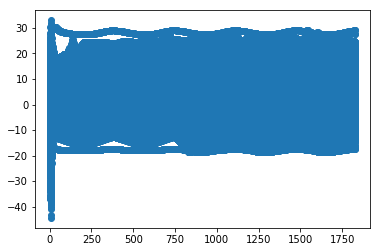

In [169]:
plt.scatter(timereg[days_pred:,:], np.asarray(predictions))

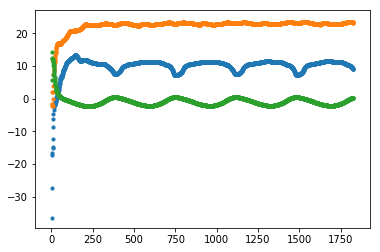

In [170]:
plt.scatter(timereg[days_pred:,50], np.asarray(predictions)[:,50], s=10)
plt.scatter(timereg[days_pred:,0], np.asarray(predictions)[:,672], s=10)
plt.scatter(timereg[days_pred:,10], np.asarray(predictions)[:,10], s=10)
plt.savefig(pathfig+'prediction_temp.png', bboxes_inches='tight')

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/GHCN_Prec_5neighbours_K5_less_random/model-4992


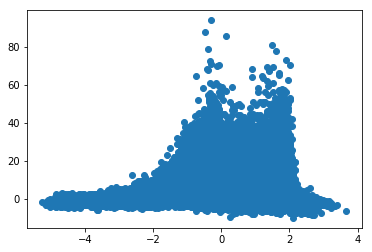

In [25]:
res = model.predict(np.atleast_3d(x_train))#(np.atleast_3d((dataset_super[:,:,0]-mean)/std))
# plt.scatter(x_train[:,:,days_pred-1], res)
plt.scatter(x_train[:,:,0], res)
# plt.scatter(x_train[:,:,0]*mask[:limit,:,0], res*mask[:limit,:,1])

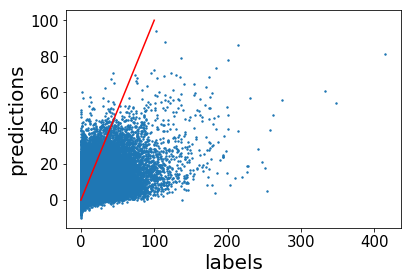

In [33]:
# plt.scatter(np.atleast_3d(dataset_temp[:,:,1]), res)
# plt.scatter(labels_train*mask[:limit,:,1], res*mask[:limit,:,1])
plt.scatter(labels_train, res, s=2)
plt.plot([0, 100],[0, 100], 'r')
plt.xlabel('labels', fontsize=20)
plt.ylabel('predictions', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.plot(range(np.min(labels_train).astype(int), np.max(labels_train).astype(int)+1), 
#          range(np.min(labels_train).astype(int), np.max(labels_train).astype(int)+1), 'r')
plt.savefig(pathfig+'prec_reg_results.png', bboxes_inches='tight')

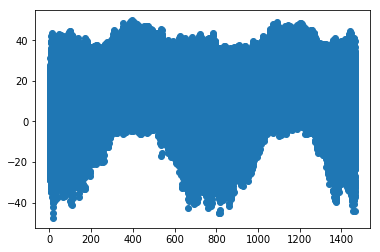

In [91]:
plt.scatter(timereg[days_pred:365*4+days_pred,:], res[:365*4,:])
# plt.scatter(timesnow[:,:], res)
# plt.scatter(timesnow[:,:], labels_train, s=5)

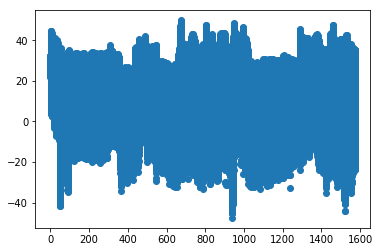

In [92]:
plt.scatter(placereg[days_pred:365*4+days_pred,:], res[:365*4,:])

In [170]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [130]:
res = np.asarray(predictions)

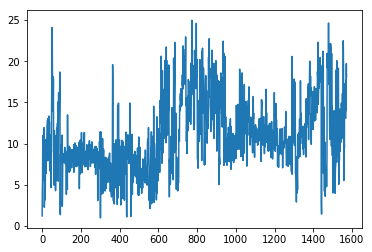

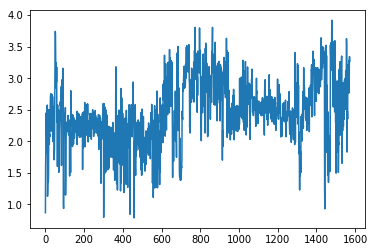

In [172]:
mse_loc = []
mae_loc = []
for i in range(res.shape[1]):
#     mse_loc.append(mse(dataset_temp[:,i,1], res[:,i]))
#     mae_loc.append(mae(dataset_temp[:,i,1], res[:,i]))
#     mse_loc.append(mse(labels_train[:,i]*mask[:limit,i,1], res[:,i]*mask[:limit,i,1]))
#     mae_loc.append(mae(labels_train[:,i]*mask[:limit,i,1], res[:,i]*mask[:limit,i,1]))
    mse_loc.append(mse(labels_train[:,i], res[:,i]))
    mae_loc.append(mae(labels_train[:,i], res[:,i]))
plt.plot(mse_loc)
plt.figure()
plt.plot(mae_loc)

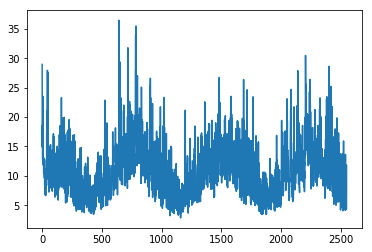

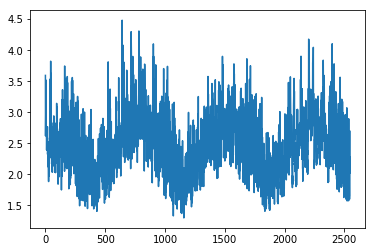

In [175]:
mse_tab = []
mae_tab = []
for i in range(res.shape[0]-1):
#     mse_tab.append(mse(dataset_temp[i,:,1], res[i,:]))
#     mse_tab.append(mse(labels_train[i,:]*mask[i,:,1], res[i,:]*mask[i,:,1]))
    mse_tab.append(mse(labels_train[i,:], res[i,:]))
    mae_tab.append(mae(labels_train[i,:], res[i,:]))
plt.plot(mse_tab)
plt.figure()
plt.plot(mae_tab)

In [176]:
arg = np.argmax(mse_tab)

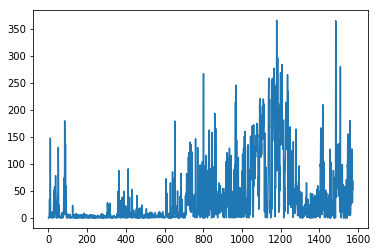

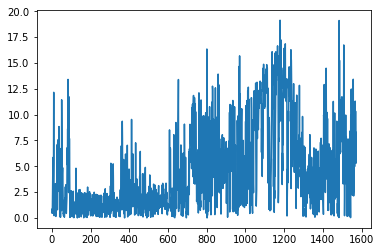

In [181]:
mse_loc = []
mae_loc = []
index = []
for i in range(res.shape[1]):
    mse_loc.append(mse([labels_train[arg,i]], [res[arg,i]]))
    mae_loc.append(mae([labels_train[arg,i]], [res[arg,i]]))
    if mae_loc[-1]>7:
        index.append(i)
plt.plot(mse_loc)
plt.figure()
plt.plot(mae_loc)
index = np.asarray(index)

In [91]:
masknan = mask.copy()
masknan[masknan==0] = np.nan

In [97]:
np.max(labels_train[arg,:])

42.5

In [98]:
np.max(res[arg,:])

37.71155548095703

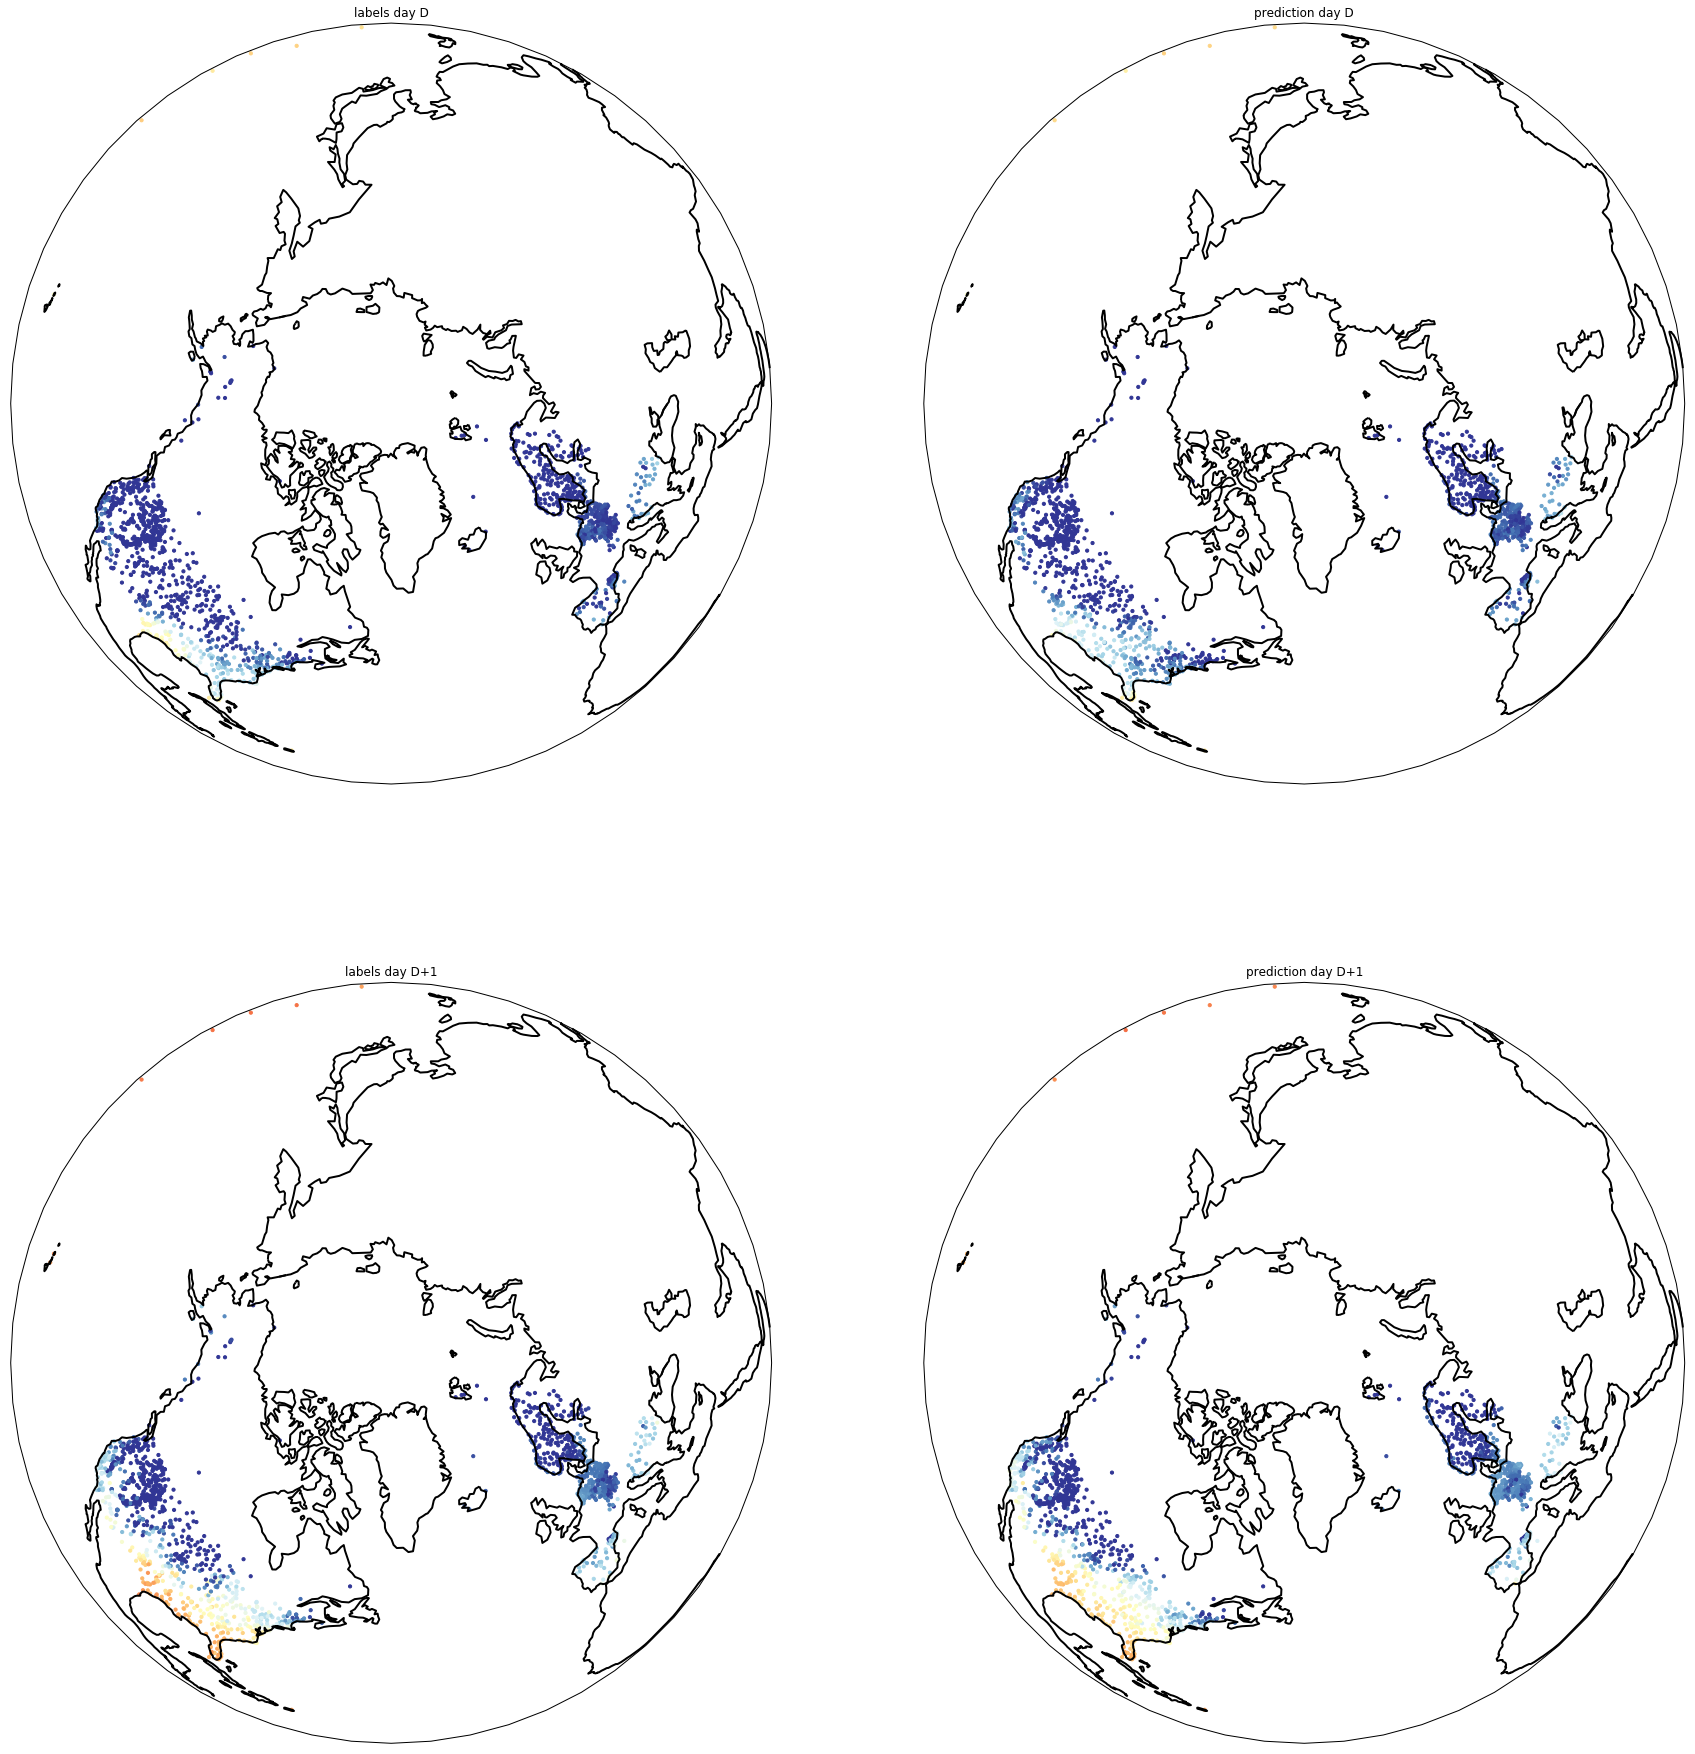

In [178]:
fig = plt.figure(figsize=(30, 50))
ax = fig.add_subplot(3, 2, 1, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('labels day D')

zmin, zmax = 0, 40

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(labels_train[arg, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 c=np.clip(labels_train[arg, :]*masknan[arg, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 2, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('prediction day D')


sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(res[arg, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 c=np.clip(res[arg, :]*masknan[arg, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 4, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('prediction day D+1')

sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(res[arg+1, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 c=np.clip(res[arg+1, :]*masknan[arg+1, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# ax = fig.add_subplot(3, 2, 5, projection=ccrs.Orthographic(-50, 90))
# ax.set_global()
# ax.coastlines(linewidth=2)
# ax.set_title('given D day D-1')


# sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
#                 c=np.clip(x_train[arg, :, days_pred-1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(3, 2, 3, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('labels day D+1')


sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
                c=np.clip(labels_train[arg+1, :], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

# ax = fig.add_subplot(3, 2, 6, projection=ccrs.Orthographic(-50, 90))
# ax.set_global()
# ax.coastlines(linewidth=2)
# ax.set_title('given D+1 day D-1')

# sc = ax.scatter(lon[keepToo], lat[keepToo], s=10,
#                 c=np.clip(x_train[arg+1, :, days_pred-2], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
#                 vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

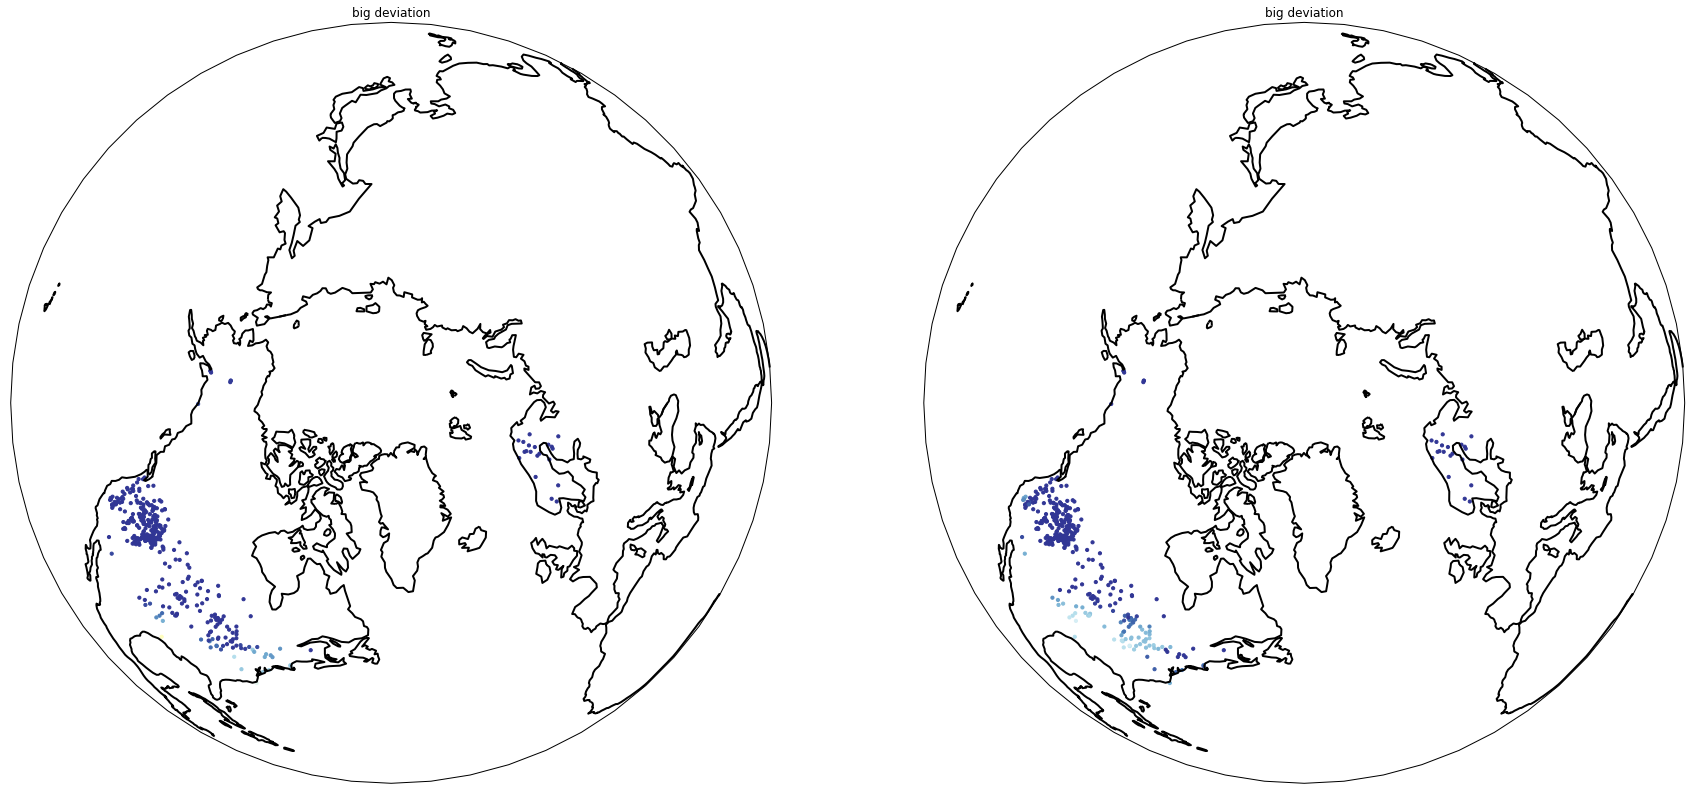

In [182]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(121, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('big deviation')


sc = ax.scatter(lon[keepToo][index], lat[keepToo][index], s=10,
                c=np.clip(labels_train[arg, :][index], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(122, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('big deviation')


sc = ax.scatter(lon[keepToo][index], lat[keepToo][index], s=10,
                c=np.clip(res[arg, :][index], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

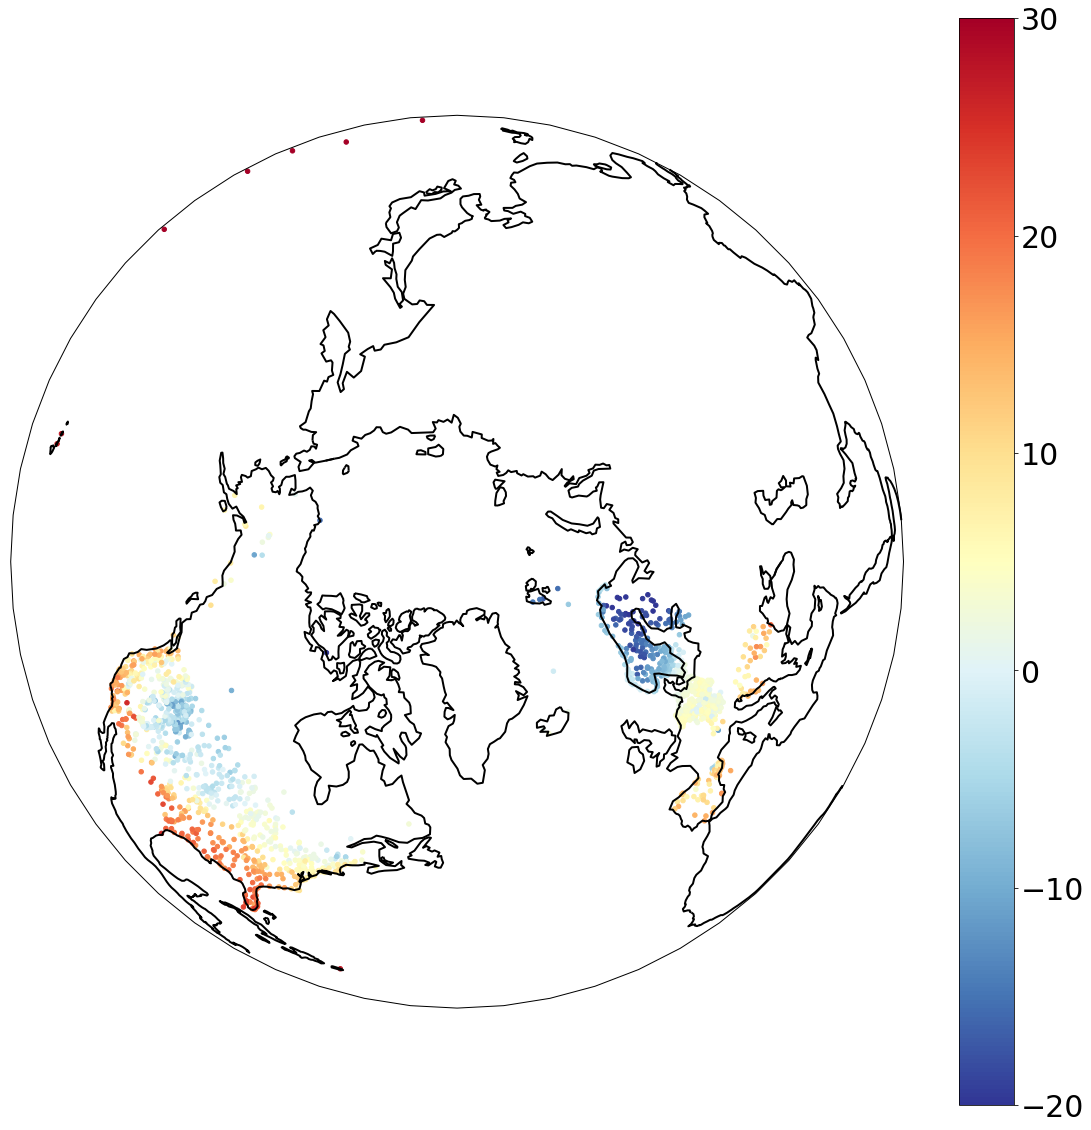

In [82]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=ccrs.Orthographic(-50, 90))
ax.set_global()
ax.coastlines(linewidth=2)
ax.set_title('', fontsize=20)

zmin = -20
zmax = 30

sc = ax.scatter(lon[keepToo], lat[keepToo], s=20,
                c=np.clip(dataset_temp_reg[50, :, 1], zmin, zmax), cmap=plt.get_cmap('RdYlBu_r'),
                vmin=zmin, vmax=zmax, alpha=1, transform=ccrs.PlateCarree())

cbar = plt.colorbar(sc, ax=ax)
cbar.ax.tick_params(labelsize=30)

plt.savefig(pathfig+"temp_min.png", bboxes_inches='tight')

classification results

In [38]:
from sklearn.metrics import accuracy_score

In [45]:
acc_loc = []
acc_time = []
acc_class = []
for i in range(res.shape[0]):
    acc_time.append(accuracy_score(labels_train[i,:], res[i,:]))
plt.plot(acc_time)
plt.figure()
for i in range(res.shape[1]):
    acc_loc.append(accuracy_score(labels_train[:,i], res[:,i]))
plt.plot(acc_loc)
plt.figure()
for i in range(6):
    index = np.where(labels_train == i)
    acc_class.append(accuracy_score(labels_train[index], res[index]))
plt.plot(acc_class)

NameError: name 'accuracy_score' is not defined

In [ ]:
loc = np.argmin(acc_loc)
arg = np.argmin(acc_time)

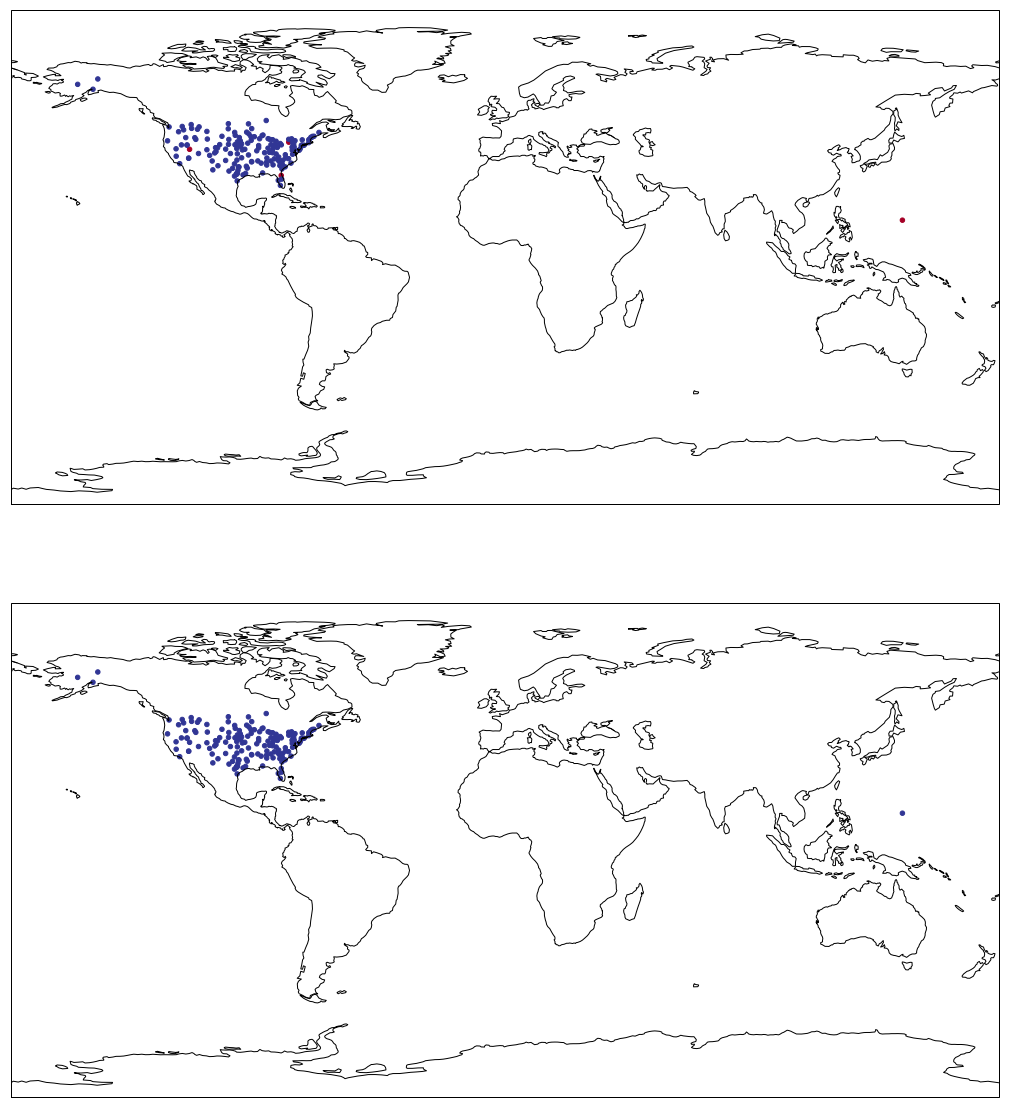

In [42]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon[keepToo], lat[keepToo], s=20,
            c=labels[arg, :], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

ax = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon[keepToo], lat[keepToo], s=20,
            c=res[arg, :], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

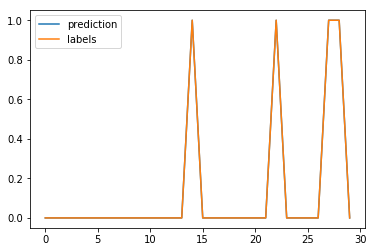

In [41]:
plt.plot(res[:30,loc], label='prediction')
plt.plot(labels_train[:30,loc], label='labels')
plt.legend()

## Figures

In [16]:
pathfig = './figures/'

In [13]:
g_full = sphereGraph(lon, lat, 2, rad=False, epsilon=False)

2019-06-26 17:45:12,669:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


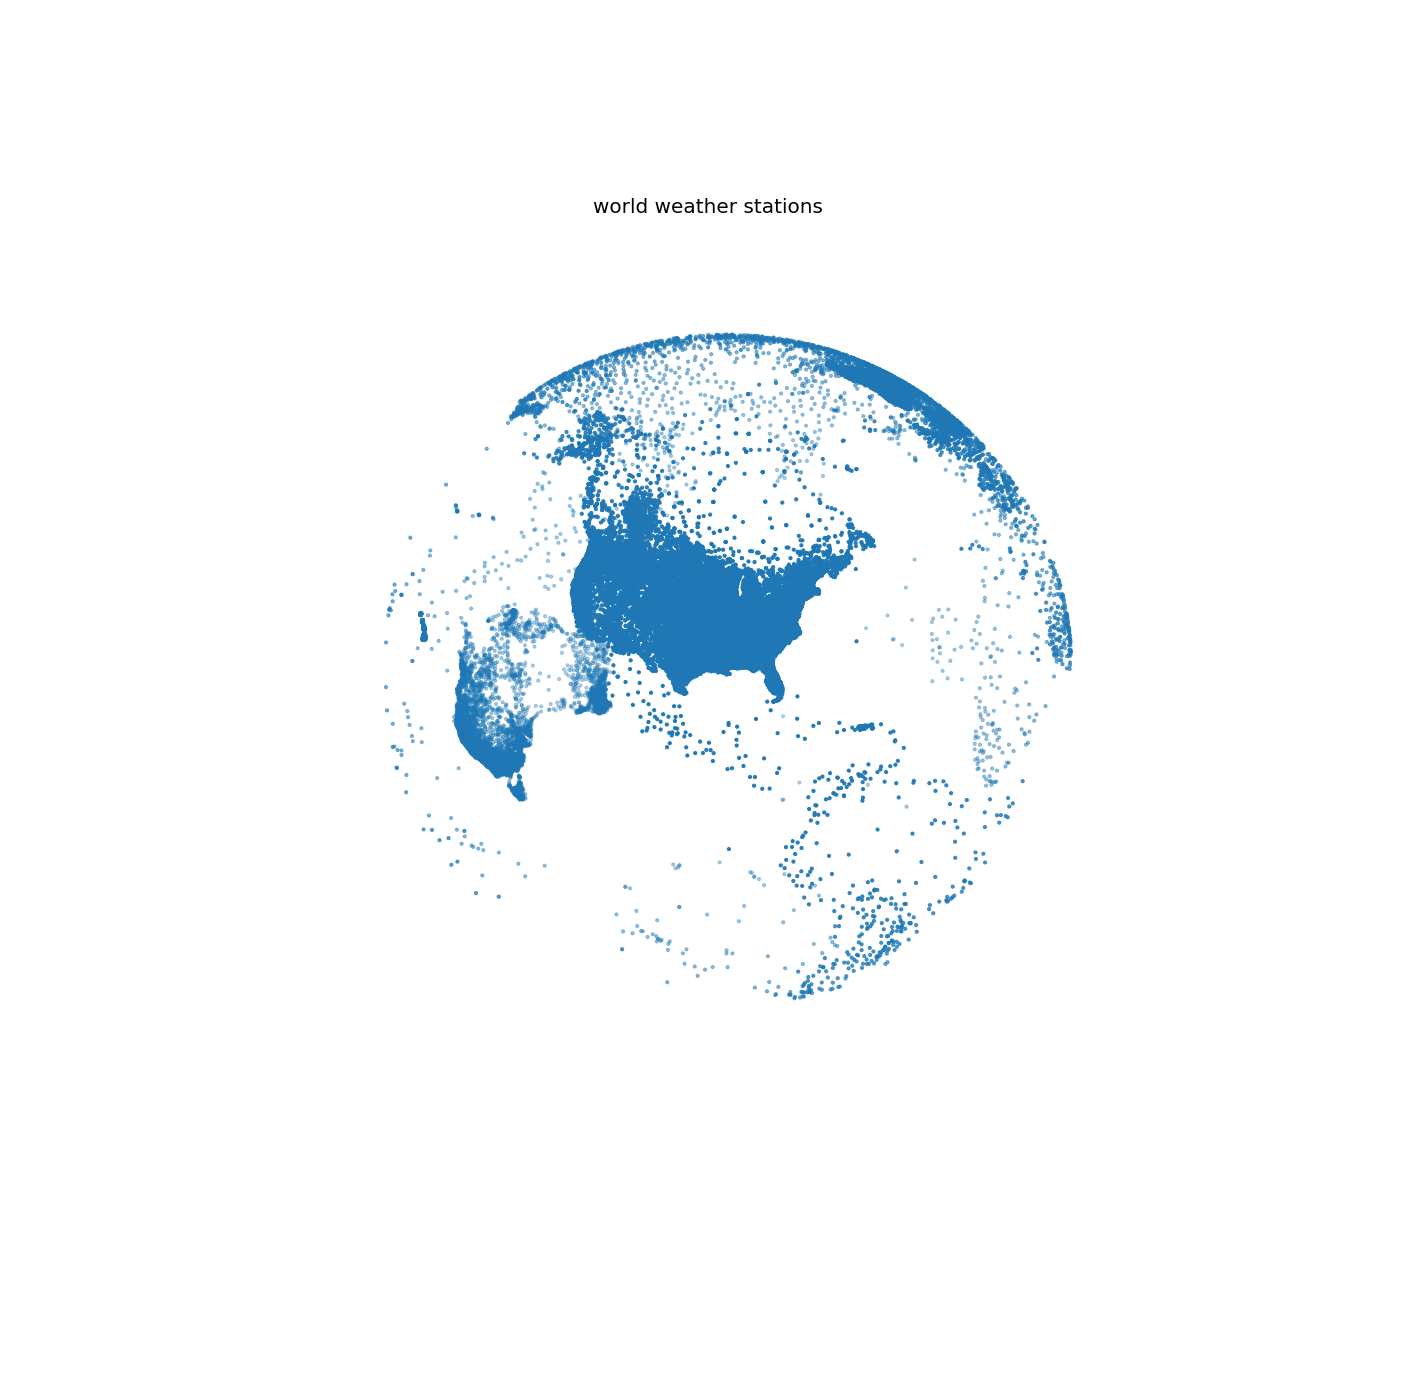

In [136]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111, projection='3d')
g_full.plot(vertex_size=10, edges=False, ax=ax)
ax.set_title('world weather stations', fontsize=20)
ax.view_init(azim=90)
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.axis('off')
plt.savefig(pathfig+"world_graph_USA.svg", bboxes_inches='tight')

In [19]:
g_full.compute_laplacian("normalized")
g_full.compute_fourier_basis(recompute=True, n_eigenvectors=500)
g_full.set_coordinates(g_full.U[:,1:4])
g_full.plot(vertex_size=10)

In [ ]:
plt.plot(g_full.e[:16], 'o')